In [1]:
# TODO
# Visualizing the demand?
# Share of annual output per storage technology
# more comprehensive correlation analysis: n technologies with most generation / consumption and their generation and capacity correlation

## Imports

In [66]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
from datetime import datetime
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse 
from utils import resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal
from utils import c_el_gen_s, c_el_con_s

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [3]:
# Network imports
n_no =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n_h2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]
markers =["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

In [5]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["STST", "EXP"])

    for c in carriers:
        result.loc["STST" , c] = df_no[c].values
        result.loc["EXP" , c] = df_h2[c].values
    return result

def c_gen(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.generators.carrier.unique().tolist():
            result.append(c)
    return result

def c_link(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.links.carrier.unique().tolist():
            result.append(c)
    return result

def c_su(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.storage_units.carrier.unique().tolist():
            result.append(c)
    return result

In [6]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [7]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units

for n in [n_no, n_h2]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # generation in TWh (does this have to be multiplied by 3??
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000 * 3
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000 * 3
        # lmps
        # capacity factors This calculation is correct? as capacity is multiplied by 2920 is the same as multiplying the generation by 3 and then dividing it by the capacity times 8760 (as cap is in MWh?)
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)


    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000 * 3
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) *2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000 * 3
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) *2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == n_no:
        df_no_ons = df_regions_onshore
        df_no_off = df_regions_offshore

    if n == n_h2:
        df_h2_ons = df_regions_onshore
        df_h2_off = df_regions_offshore

df_no_ons.head()

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   
AT0 2  POLYGON ((13.47802 46.56357, 13.23111 46.55217...   
BA0 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...   

                                         coords   name  offwind-ac_mv  \
name                                                                    
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0     126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0            NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1            NaN   
AT0 2   (13.805469952867842, 47.57283376100011)  AT0 2            NaN   
BA0 0    (17.97055162265331, 43.88773569750005)  BA0 0            NaN   

       offwind-ac_gen  offwind-ac_cf  onwind_mv    onwind_gen  onwind_cf  \
name                                                                       
AL0 0        0.029238       0.090705        NaN      0.015125   0.038018   
AT0 0             NaN            NaN  83.457109  30395.904252   0.149667   
AT0 1             NaN            NaN        NaN      0.000348   0.004685   
AT0 2             NaN            NaN        NaN      0.014320   0.039178   
BA0 0             NaN            NaN        NaN      0.014059   0.031802   

        solar_mv  ...  urban central water tanks_lmp  biogas_lmp  \
name              ...                                              
AL0 0  44.628736  ...                      43.532557  113.716896   
AT0 0  54.679083  ...                      55.231280  113.716896   
AT0 1  65.745903  ...                      55.553668  113.716896   
AT0 2  58.223787  ...                      58.936874  113.716896   
BA0 0  51.160537  ...                      51.074197  113.716896   

       solid biomass_lmp  solid biomass for industry_lmp  \
name                                                       
AL0 0         102.453861                       78.924392   
AT0 0         102.453861                       78.924392   
AT0 1         102.453861                       78.924392   
AT0 2         102.453861                       78.924392   
BA0 0         102.453861                       78.924392   

       gas for industry_lmp  H2 liquid_lmp    oil_lmp  process emissions_lmp  \
name                                                                           
AL0 0            113.135704     137.617875  50.009981            -408.520212   
AT0 0            113.135704     151.448316  50.009981            -408.520212   
AT0 1            113.135704     154.026970  50.009981            -408.520212   
AT0 2            113.135704     148.663198  50.009981            -408.520212   
BA0 0            113.135704     147.689672  50.009981            -408.520212   

       low voltage_lmp  home battery_lmp  
name                                      
AL0 0       100.338046        100.380697  
AT0 0       115.006246        115.044440  
AT0 1       121.910720        121.947576  
AT0 2       112.352878        112.386673  
BA0 0       112.040690        112.006725  

[5 rows x 233 columns]

In [8]:
#assert 0


# 4.2 Important Technologies and their role

## Electricity Balances

In [62]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
period = "2013-05"
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2 = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no.rename(columns=carrier_renaming, inplace=True)
nb_el_h2.rename(columns=carrier_renaming, inplace=True)

nb_el_no.head(3)

carrier                        AC  BEV charger       DAC            DC  \
snapshot                                                                 
2013-05-01 00:00:00  1.728040e-14   -55.936232 -4.846786  1.364242e-15   
2013-05-01 03:00:00  7.275958e-15   -50.782888 -4.846752 -2.273737e-16   
2013-05-01 06:00:00  5.456968e-15  -352.207515 -4.846783  2.273737e-16   

carrier              H2 Electrolysis  H2 Fuel Cell        PHS        V2G  \
snapshot                                                                   
2013-05-01 00:00:00      -709.514501           NaN   4.023339  29.945463   
2013-05-01 03:00:00      -671.842886           NaN   7.678835  21.005248   
2013-05-01 06:00:00     -1932.708992           NaN -66.944392   7.030831   

carrier              battery charger  battery discharger  ...  solar rooftop  \
snapshot                                                  ...                  
2013-05-01 00:00:00        -0.997366          222.558061  ...            NaN   
2013-05-01 03:00:00        -0.124167          200.931540  ...       9.973257   
2013-05-01 06:00:00      -231.662255            0.682652  ...     243.879720   

carrier              gas CHP  gas CHP CC  biomass CHP CC  resistive heater  \
snapshot                                                                     
2013-05-01 00:00:00      NaN         NaN        2.601915         -1.135108   
2013-05-01 03:00:00      NaN         NaN       12.405591         -8.685297   
2013-05-01 06:00:00      NaN         NaN        0.005410        -28.003127   

carrier              gas boiler   heat pump  water tanks charger  \
snapshot                                                           
2013-05-01 00:00:00         0.0 -230.271011                  0.0   
2013-05-01 03:00:00         0.0 -303.697183                  0.0   
2013-05-01 06:00:00         0.0 -302.569416                  0.0   

carrier              water tanks discharger  solar thermal  
snapshot                                                    
2013-05-01 00:00:00                     0.0            0.0  
2013-05-01 03:00:00                     0.0            0.0  
2013-05-01 06:00:00                     0.0            0.0  

[3 rows x 28 columns]

In [63]:
# differences
nb_el_no.columns.difference(nb_el_h2.columns)

Index(['DAC', 'H2 Fuel Cell', 'gas CHP', 'gas CHP CC'], dtype='object', name='carrier')

- network without H2 grid has no 'biomass CHP'
- network with H2 grid has no Direct Air Capture, no H2 Fuel Cell, no gas CHP and no gas CHP CC

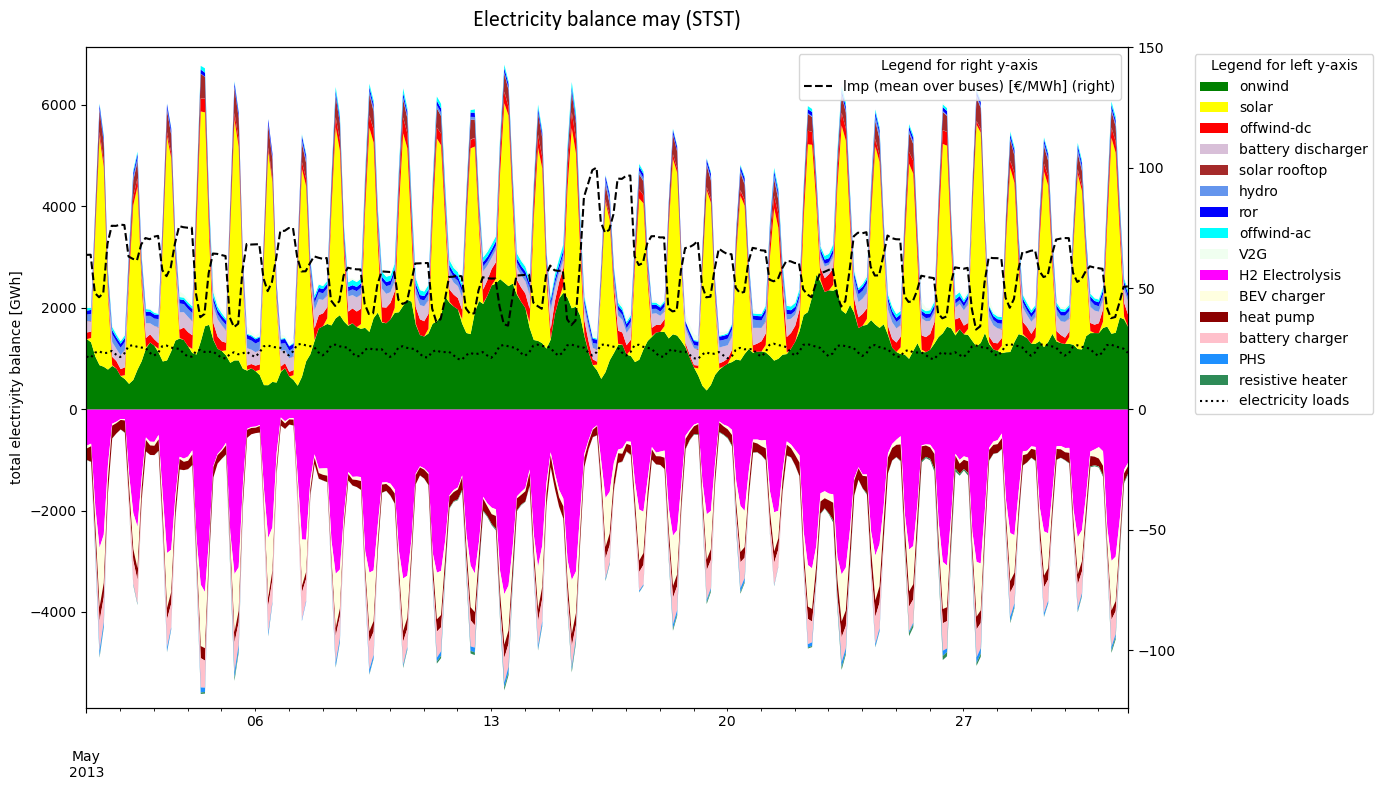

In [64]:
# thesis_plot

fig, ax = plt.subplots(figsize=(14, 8))

n = n_no
df = nb_el_no
df_loads = loads_el_no

# split into df with positive and negative values
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
# exclude all technologies that contribute less than th
th = 0.005
df_pos_share = df_pos.sum() / df_pos.sum().sum()
df_pos = df_pos[df_pos_share[df_pos_share > th].sort_values(ascending=False).index]
df_neg_share = df_neg.sum() / df_neg.sum().sum()
df_neg = df_neg[df_neg_share[df_neg_share > th].sort_values(ascending=False).index]
# get colors
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values that are also present on positive side, so that they are not shown and plot negative values
f = lambda c: '_' + c
cols = [f(c) if (c in df_pos.columns) else c for c in  df_neg.columns]
cols_map = dict(zip(df_neg.columns, cols))
ax = df_neg.rename(columns=cols_map).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("total electriyity balance [GWh]")
ax.set_xlabel("")
ax.set_title("Electricity balance may (STST)", fontsize=16, pad=15,  **font1)
fig.tight_layout()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_may_STST.png")

Further analysis

In [ ]:
# check if technologies are ein plot which are not in index
set(df_pos.columns).difference(c_el_gen_s)
set(c_el_gen_s).difference(df_pos.columns)
# gen: 'PHS', 'urban central gas CHP', 'urban central solid biomass CHP CC' are not in plot but in index
# con: 'urban central air heat pump', 'urban central resistive heater' are present aggregated

In [74]:
set(df_neg.columns).difference(c_el_con_s)

{'heat pump', 'resistive heater'}

In [12]:
df_pos.sum()

carrier
onwind                345562.363252
solar                 338931.403660
offwind-dc             48960.333114
battery discharger     34117.878432
solar rooftop          33399.696680
hydro                  21041.679416
ror                    20065.206325
offwind-ac             14179.441963
V2G                     8102.933107
PHS                     3354.711438
biomass CHP CC          2211.845531
dtype: float64

- onwind only slighlty with most generation (not the case for June, July and August)
onwind,345562.363252
solar,338931.403660

In [13]:
df_neg

carrier              H2 Electrolysis  BEV charger   heat pump  \
snapshot                                                        
2013-05-01 00:00:00      -709.514501   -55.936232 -230.271011   
2013-05-01 03:00:00      -671.842886   -50.782888 -303.697183   
2013-05-01 06:00:00     -1932.708992  -352.207515 -302.569416   
2013-05-01 09:00:00     -2727.122164 -1169.842882 -277.173022   
2013-05-01 12:00:00     -2465.729728  -951.646293 -283.033166   
...                              ...          ...         ...   
2013-05-31 09:00:00     -2983.349810  -980.009512 -180.608449   
2013-05-31 12:00:00     -2899.633047  -878.887014 -195.575599   
2013-05-31 15:00:00     -2145.802741  -368.392123 -208.205952   
2013-05-31 18:00:00     -1185.307630   -70.931135 -174.324832   
2013-05-31 21:00:00     -1041.080994   -68.364870 -140.713234   

carrier              battery charger         PHS  resistive heater       DAC  
snapshot                                                                      
2013-05-01 00:00:00        -0.997366    0.000000         -1.135108 -4.846786  
2013-05-01 03:00:00        -0.124167    0.000000         -8.685297 -4.846752  
2013-05-01 06:00:00      -231.662255  -66.944392        -28.003127 -4.846783  
2013-05-01 09:00:00      -579.542177 -113.215714        -23.454737 -4.846792  
2013-05-01 12:00:00      -486.231291  -88.912298        -21.570060 -4.846303  
...                              ...         ...               ...       ...  
2013-05-31 09:00:00      -535.224385  -73.327041        -44.189621 -4.823103  
2013-05-31 12:00:00      -451.781806  -56.584516        -50.136552 -4.822735  
2013-05-31 15:00:00       -48.454321  -21.485765        -52.209747 -4.822576  
2013-05-31 18:00:00        -0.961708    0.000000        -20.626903 -4.822447  
2013-05-31 21:00:00        -1.060503    0.000000        -19.875922 -4.822629  

[248 rows x 7 columns]

In [14]:
# correlation of solar generation and lmp
nb_el_no[["solar", "solar rooftop"]].sum(axis=1).corr(lmps) # -0.6751
nb_el_no.onwind.corr(lmps) # -0.358751
nb_el_no.PHS.corr(lmps) # 0.78373
nb_el_no.PHS.corr(nb_el_no.solar) # -0.9022

-0.9022293674223766

In [15]:
# range of lmps
lmps.describe()

count    248.000000
mean      57.967083
std       12.923232
min       32.973028
25%       48.458793
50%       57.546951
75%       65.653280
max      100.124028
dtype: float64

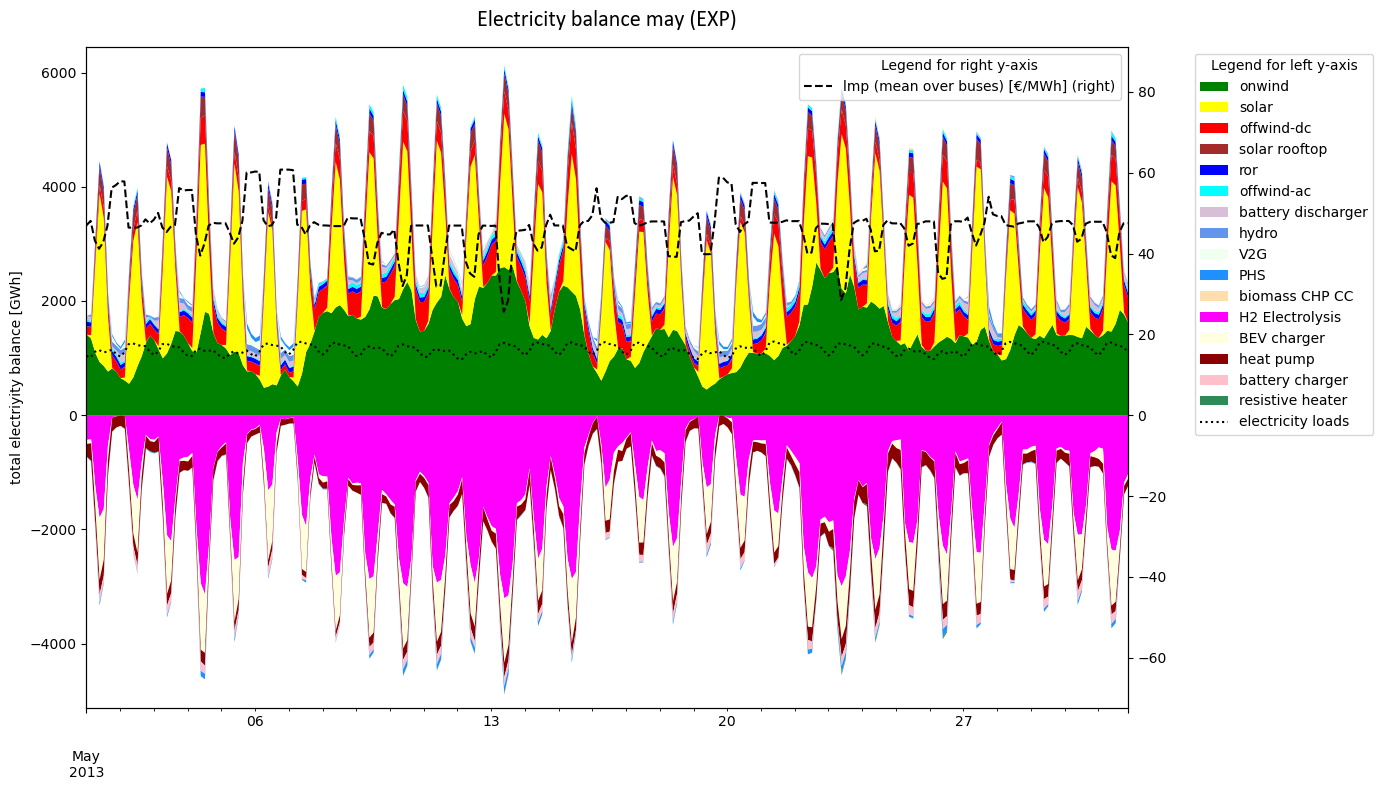

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_h2
df = nb_el_h2
df_loads = loads_el_h2

# split into df with positive and negative values
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
# exclude all technologies that contribute less than th
th = 0.001
df_pos_share = df_pos.sum() / df_pos.sum().sum()
df_pos = df_pos[df_pos_share[df_pos_share > th].sort_values(ascending=False).index]
df_neg_share = df_neg.sum() / df_neg.sum().sum()
df_neg = df_neg[df_neg_share[df_neg_share > th].sort_values(ascending=False).index]
# get colors
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values that are also present on positive side, so that they are not shown and plot negative values
f = lambda c: '_' + c
cols = [f(c) if (c in df_pos.columns) else c for c in  df_neg.columns]
cols_map = dict(zip(df_neg.columns, cols))
ax = df_neg.rename(columns=cols_map).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("total electriyity balance [GWh]")
ax.set_xlabel("")
ax.set_title("Electricity balance may (EXP)", fontsize=16, pad=15,  **font1)
fig.tight_layout()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_may_EXP.png")

In [17]:
# range of lmps
lmps.describe()

count    248.000000
mean      46.563079
std        5.898544
min       25.604811
25%       44.750596
50%       47.117279
75%       48.025135
max       60.767309
dtype: float64

### Electricity Balance (Jan)

In [18]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
period = "2013-01"
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2 = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no.rename(columns=carrier_renaming, inplace=True)
nb_el_h2.rename(columns=carrier_renaming, inplace=True)

nb_el_no.head(3)

carrier                        AC  BEV charger       DAC            DC  \
snapshot                                                                 
2013-01-01 00:00:00  1.182343e-14  -471.667750 -4.701310  1.818989e-15   
2013-01-01 03:00:00  1.455192e-14  -339.458588 -4.701299 -2.728484e-15   
2013-01-01 06:00:00 -2.182787e-14  -459.324499 -4.701317  2.273737e-15   

carrier              H2 Electrolysis  H2 Fuel Cell  OCGT       PHS       V2G  \
snapshot                                                                       
2013-01-01 00:00:00     -2086.685643           NaN   NaN -8.191668  5.377617   
2013-01-01 03:00:00     -1902.041094           NaN   NaN  2.064618  7.421831   
2013-01-01 06:00:00     -1845.437240           NaN   NaN -9.096095  1.615203   

carrier              battery charger  ...  solar rooftop    gas CHP  \
snapshot                              ...                             
2013-01-01 00:00:00       -27.560361  ...            NaN  26.784181   
2013-01-01 03:00:00       -30.929961  ...            NaN  42.072599   
2013-01-01 06:00:00      -102.300655  ...      52.107755   7.057945   

carrier              gas CHP CC  biomass CHP CC  resistive heater  gas boiler  \
snapshot                                                                        
2013-01-01 00:00:00    0.002446       72.685865        -50.220569         0.0   
2013-01-01 03:00:00    0.002457       73.037867       -218.312261         0.0   
2013-01-01 06:00:00    0.002455       73.186171       -273.810208         0.0   

carrier               heat pump  water tanks charger  water tanks discharger  \
snapshot                                                                       
2013-01-01 00:00:00 -403.124125                  0.0                     0.0   
2013-01-01 03:00:00 -488.455926                  0.0                     0.0   
2013-01-01 06:00:00 -498.409860                  0.0                     0.0   

carrier              solar thermal  
snapshot                            
2013-01-01 00:00:00            0.0  
2013-01-01 03:00:00            0.0  
2013-01-01 06:00:00            0.0  

[3 rows x 29 columns]

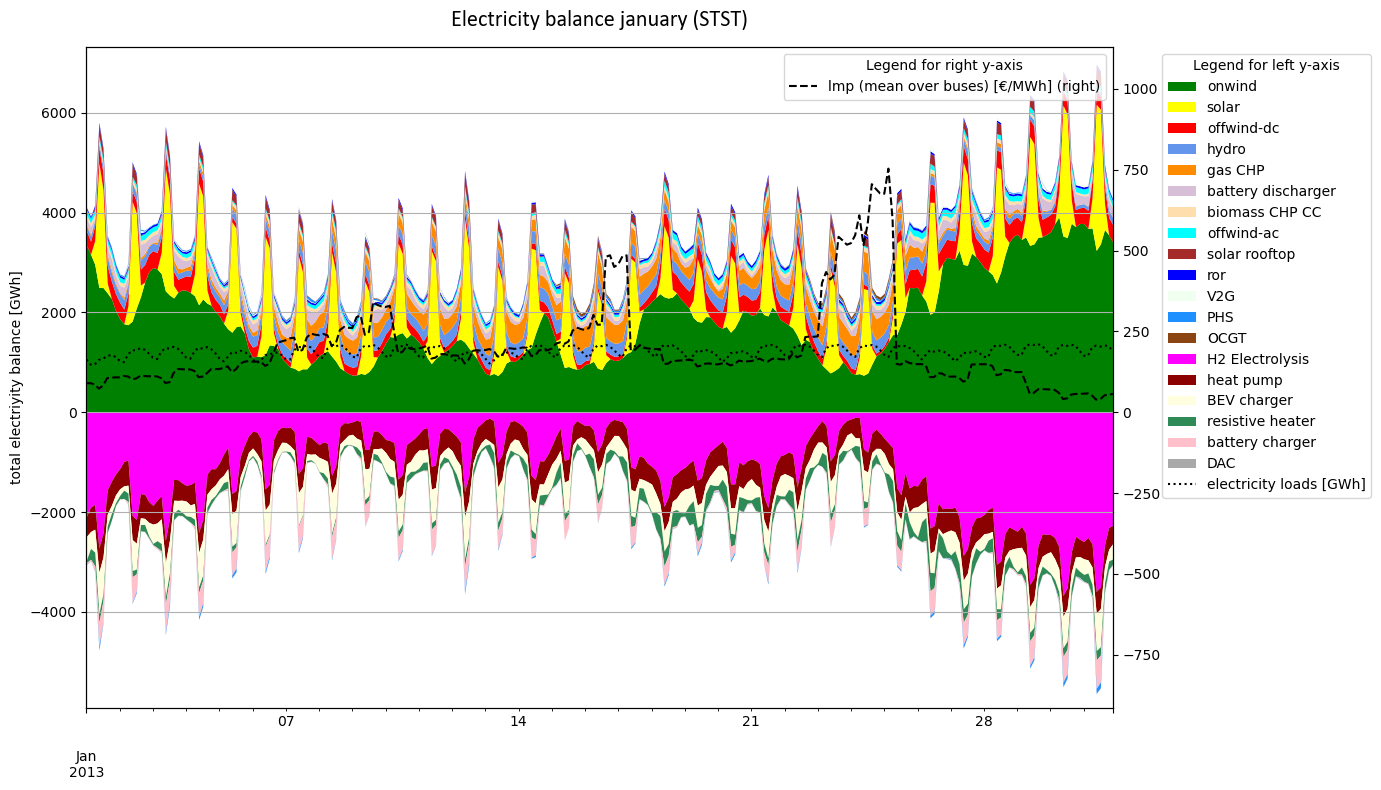

In [19]:
# thesis plot

fig, ax = plt.subplots(figsize=(14, 8))

n = n_no
df = nb_el_no
df_loads = loads_el_no

# split into df with positive and negative values
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
# exclude all technologies that contribute less than th
th = 0.001
df_pos_share = df_pos.sum() / df_pos.sum().sum()
df_pos = df_pos[df_pos_share[df_pos_share > th].sort_values(ascending=False).index]
df_neg_share = df_neg.sum() / df_neg.sum().sum()
df_neg = df_neg[df_neg_share[df_neg_share > th].sort_values(ascending=False).index]
# get colors
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values that are also present on positive side, so that they are not shown and plot negative values
f = lambda c: '_' + c
cols = [f(c) if (c in df_pos.columns) else c for c in  df_neg.columns]
cols_map = dict(zip(df_neg.columns, cols))
ax = df_neg.rename(columns=cols_map).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("total electriyity balance [GWh]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title("Electricity balance january (STST)", fontsize=16, pad=15,  **font1)
fig.tight_layout()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_jan_STST.png")

In [20]:
# range of lmps
lmps.describe()

count    248.000000
mean     198.406902
std      130.235958
min       38.643497
25%      124.710413
50%      162.967965
75%      215.261822
max      753.467762
dtype: float64

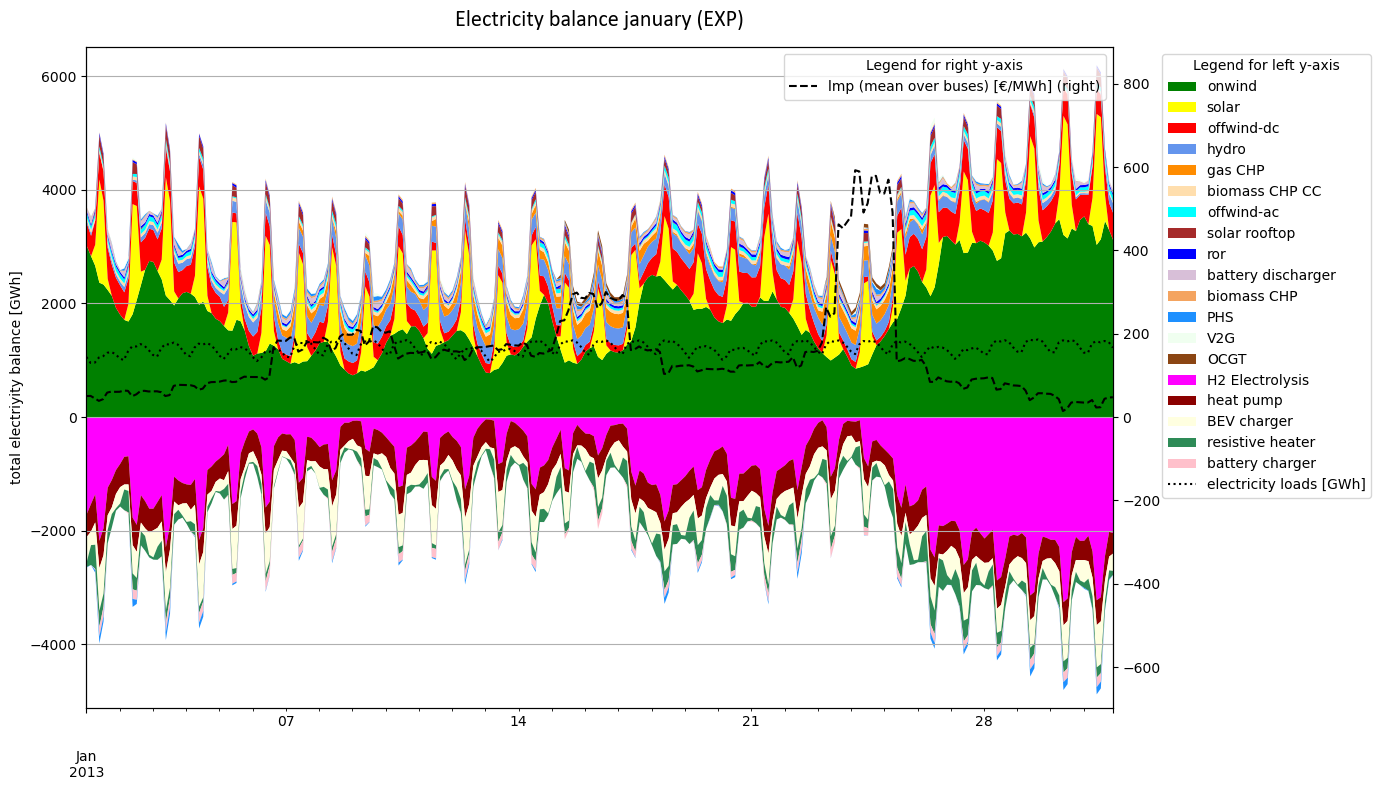

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_h2
df = nb_el_h2
df_loads = loads_el_h2

# split into df with positive and negative values
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
# exclude all technologies that contribute less than th
th = 0.001
df_pos_share = df_pos.sum() / df_pos.sum().sum()
df_pos = df_pos[df_pos_share[df_pos_share > th].sort_values(ascending=False).index]
df_neg_share = df_neg.sum() / df_neg.sum().sum()
df_neg = df_neg[df_neg_share[df_neg_share > th].sort_values(ascending=False).index]
# get colors
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values that are also present on positive side, so that they are not shown and plot negative values
f = lambda c: '_' + c
cols = [f(c) if (c in df_pos.columns) else c for c in  df_neg.columns]
cols_map = dict(zip(df_neg.columns, cols))
ax = df_neg.rename(columns=cols_map).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("total electriyity balance [GWh]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title("Electricity balance january (EXP)", fontsize=16, pad=15,  **font1)
fig.tight_layout()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_jan_EXP.png")

In [22]:
# range of lmps
lmps.describe()

count    248.000000
mean     153.146098
std      111.468722
min       14.405703
25%       83.221548
50%      133.236972
75%      173.552668
max      592.367175
dtype: float64

### Electricity balance (all year)

In [23]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
period = "2013"
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=True)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no_all = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2_all = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no_all.rename(columns=carrier_renaming, inplace=True)
nb_el_h2_all.rename(columns=carrier_renaming, inplace=True)

nb_el_no_all.head(3)

carrier                        AC  BEV charger       DAC            DC  \
snapshot                                                                 
2013-01-01 00:00:00  1.182343e-14  -471.667750 -4.701310  1.818989e-15   
2013-01-01 03:00:00  1.455192e-14  -339.458588 -4.701299 -2.728484e-15   
2013-01-01 06:00:00 -2.182787e-14  -459.324499 -4.701317  2.273737e-15   

carrier              H2 Electrolysis  H2 Fuel Cell  OCGT       PHS       V2G  \
snapshot                                                                       
2013-01-01 00:00:00     -2086.685643           NaN   NaN -8.191668  5.377617   
2013-01-01 03:00:00     -1902.041094           NaN   NaN  2.064618  7.421831   
2013-01-01 06:00:00     -1845.437240           NaN   NaN -9.096095  1.615203   

carrier              battery charger  ...  solar rooftop    gas CHP  \
snapshot                              ...                             
2013-01-01 00:00:00       -27.560361  ...            NaN  26.784181   
2013-01-01 03:00:00       -30.929961  ...            NaN  42.072599   
2013-01-01 06:00:00      -102.300655  ...      52.107755   7.057945   

carrier              gas CHP CC  biomass CHP CC  resistive heater  gas boiler  \
snapshot                                                                        
2013-01-01 00:00:00    0.002446       72.685865        -50.220569         0.0   
2013-01-01 03:00:00    0.002457       73.037867       -218.312261         0.0   
2013-01-01 06:00:00    0.002455       73.186171       -273.810208         0.0   

carrier               heat pump  water tanks charger  water tanks discharger  \
snapshot                                                                       
2013-01-01 00:00:00 -403.124125                  0.0                     0.0   
2013-01-01 03:00:00 -488.455926                  0.0                     0.0   
2013-01-01 06:00:00 -498.409860                  0.0                     0.0   

carrier              solar thermal  
snapshot                            
2013-01-01 00:00:00            0.0  
2013-01-01 03:00:00            0.0  
2013-01-01 06:00:00            0.0  

[3 rows x 29 columns]

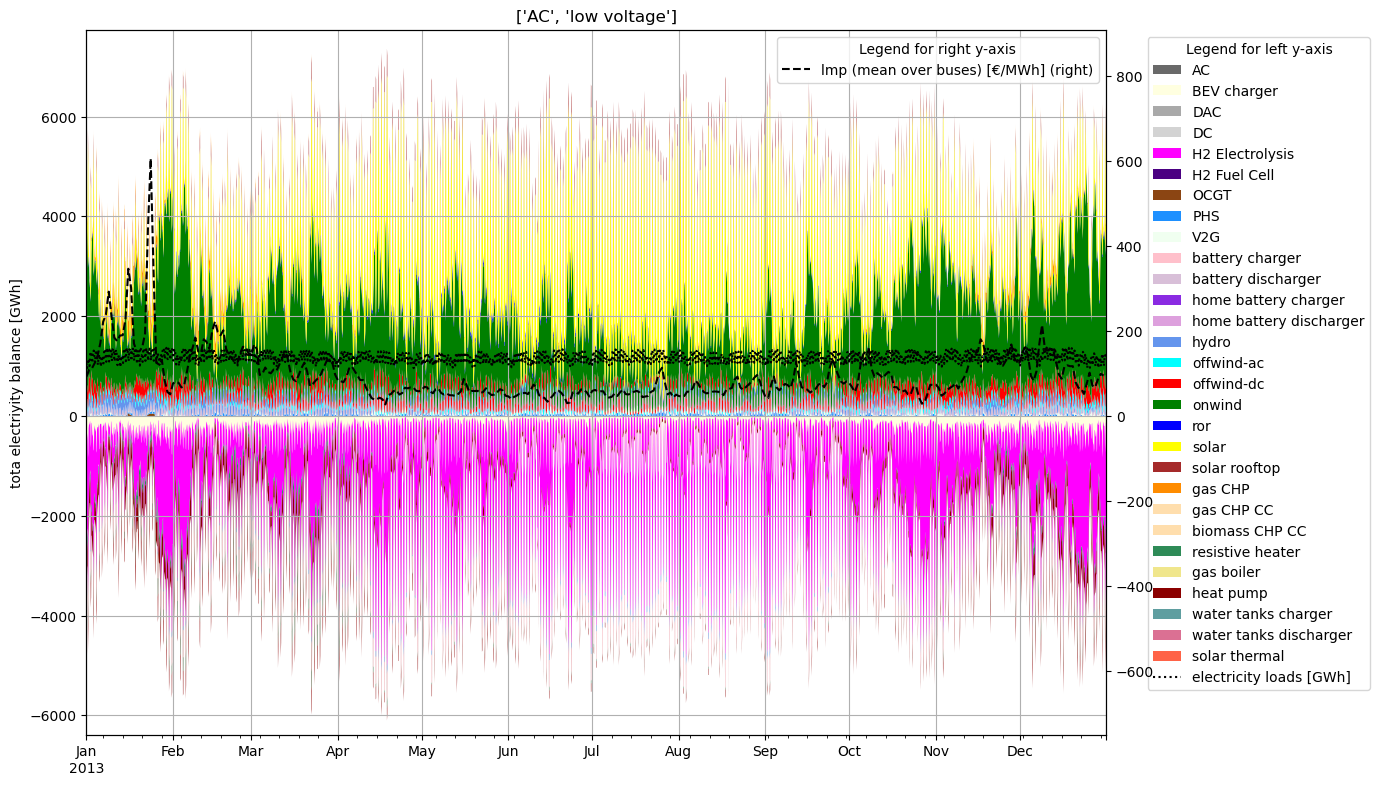

In [24]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_no
# "8h", "D", "W", "M"
res = "D"
df = nb_el_no_all#.resample(res).sum()
df_loads = loads_el_no#.resample(res).sum()

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period].resample(res).mean()
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("tota electriyity balance [GWh]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title(f"{carrier}")
fig.tight_layout()

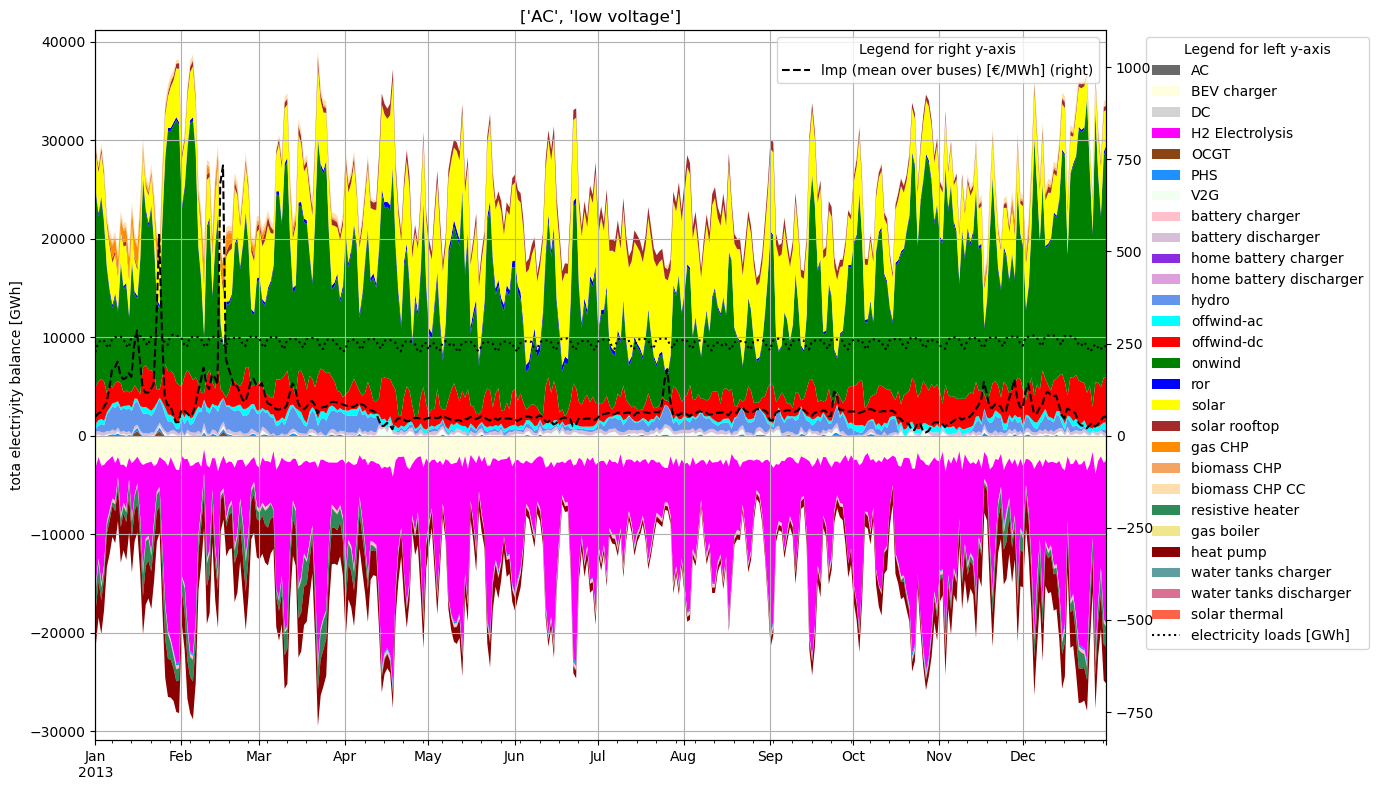

In [25]:
fig, ax = plt.subplots(figsize=(14, 8))

n = n_h2
# "8h", "D", "W", "M"
res = "D"
df = nb_el_h2_all.resample(res).sum()
df_loads = loads_el_h2.resample(res).sum()

# split into df with positive and negative values and get colors
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values so that they are not shown and plot negative values
ax = df_neg.rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period].resample(res).mean()
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("tota electriyity balance [GWh]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title(f"{carrier}")
fig.tight_layout()

### Electricity Balances special cases

In [26]:
carrier = ["AC", "low voltage"]
loads = ["electricity", "industry electricity", "agriculture electricity"]
start_date = "2013-01-23 00:00:00"
end_date = "2013-01-25 00:00:00"
period = n_no.generators_t.p.index[(n_no.generators_t.p.index >= start_date) & (n_no.generators_t.p.index <= end_date)]
nb_el_no = nodal_balance(n_no, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=False)  # in units of energy
nb_el_h2 = nodal_balance(n_h2, carrier = carrier, time=period, aggregate=['component', 'bus'], energy=False)  # in units of energy
# convert from MW to GW and unstack
nb_el_no = nb_el_no.unstack(level=[1]) / 1000
nb_el_h2 = nb_el_h2.unstack(level=[1]) / 1000
loads_el_no = abs(nb_el_no[loads].sum(axis=1))
loads_el_h2 = abs(nb_el_h2[loads].sum(axis=1))
nb_el_no.drop(loads, axis=1, inplace=True)
nb_el_h2.drop(loads, axis=1, inplace=True)

# condense groups
nb_el_no = get_condense_sum(nb_el_no, c1_groups, c1_groups_name)
nb_el_h2 = get_condense_sum(nb_el_h2, c1_groups, c1_groups_name)
# rename unhandy column names
nb_el_no.rename(columns=carrier_renaming, inplace=True)
nb_el_h2.rename(columns=carrier_renaming, inplace=True)

nb_el_no.head(3)

carrier                        AC  BEV charger       DAC        DC  \
snapshot                                                             
2013-01-23 00:00:00  2.273737e-16  -137.064159 -1.087380  0.000006   
2013-01-23 03:00:00 -4.320100e-15   -69.432767 -0.584167  0.000006   
2013-01-23 06:00:00 -1.364242e-15   -57.028803 -0.547156  0.000012   

carrier              H2 Electrolysis  H2 Fuel Cell       OCGT       PHS  \
snapshot                                                                  
2013-01-23 00:00:00       -89.229443      0.554258  11.683333  7.482773   
2013-01-23 03:00:00       -56.367059      0.554259  15.024421  9.761353   
2013-01-23 06:00:00       -90.911222      0.554259  16.304600  9.752706   

carrier                   V2G  battery charger  ...  solar rooftop  \
snapshot                                        ...                  
2013-01-23 00:00:00  1.722181        -0.901485  ...            NaN   
2013-01-23 03:00:00  2.938768        -0.018482  ...            NaN   
2013-01-23 06:00:00  1.128752       -16.131363  ...      16.517388   

carrier                 gas CHP  gas CHP CC  biomass CHP CC  resistive heater  \
snapshot                                                                        
2013-01-23 00:00:00  119.762529    0.002854       26.023862        -11.621559   
2013-01-23 03:00:00  125.505818    0.002859       26.023875        -93.406232   
2013-01-23 06:00:00  134.866186    0.002859       26.023875       -113.873389   

carrier              gas boiler   heat pump  water tanks charger  \
snapshot                                                           
2013-01-23 00:00:00         0.0 -110.587478                  0.0   
2013-01-23 03:00:00         0.0 -142.552247                  0.0   
2013-01-23 06:00:00         0.0 -140.430216                  0.0   

carrier              water tanks discharger  solar thermal  
snapshot                                                    
2013-01-23 00:00:00                     0.0            0.0  
2013-01-23 03:00:00                     0.0            0.0  
2013-01-23 06:00:00                     0.0            0.0  

[3 rows x 29 columns]

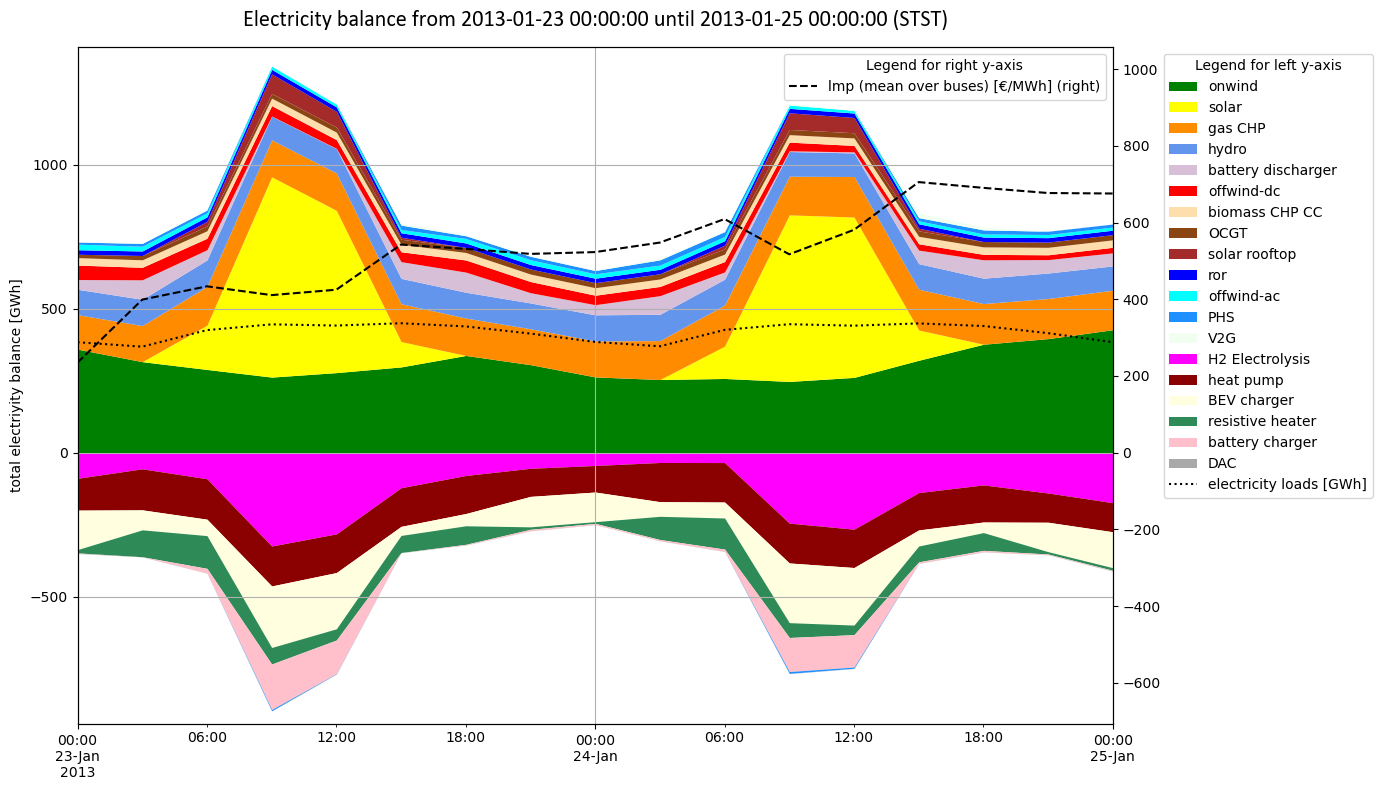

In [27]:
fig, ax = plt.subplots(figsize=(14, 8))

model = "STST"

if model == "STST":
    n = n_no
    df = nb_el_no
    df_loads = loads_el_no
elif model == "EXP":
    n = n_h2
    df = nb_el_h2
    df_loads = loads_el_h2

# split into df with positive and negative values
df_neg, df_pos = df.clip(upper=0), df.clip(lower=0)
# exclude all technologies that contribute less than th
th = 0.005
df_pos_share = df_pos.sum() / df_pos.sum().sum()
df_pos = df_pos[df_pos_share[df_pos_share > th].sort_values(ascending=False).index]
df_neg_share = df_neg.sum() / df_neg.sum().sum()
df_neg = df_neg[df_neg_share[df_neg_share > th].sort_values(ascending=False).index]
# get colors
c_neg, c_pos = [carrier_colors[col] for col in df_neg.columns], [carrier_colors[col] for col in df_pos.columns]

# plot positive values
ax = df_pos.plot.area(ax=ax, stacked=True, color=c_pos, linewidth=0.)

# rename negative values that are also present on positive side, so that they are not shown and plot negative values
f = lambda c: '_' + c
cols = [f(c) if (c in df_pos.columns) else c for c in  df_neg.columns]
cols_map = dict(zip(df_neg.columns, cols))
ax = df_neg.rename(columns=cols_map).plot.area(ax=ax, stacked=True, color=c_neg, linewidth=0.)

# plot lmps
lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier.isin(carrier)].index].mean(axis=1)[period]
ax2 = lmps.plot(style="--", color="black", label="lmp (mean over buses) [€/MWh]", secondary_y=True)
ax2.grid(False)
# set limits of secondary y-axis
ax2.set_ylim([ - 1.5 * lmps.max() * abs(df_neg.sum(axis=1).min()) /  df_pos.sum(axis=1).max() , 1.5 * lmps.max()])

# plot loads
df_loads.plot(style=":", color="black", label="electricity loads [GWh]")

# rescale the y-axis
ax.set_ylim([1.05*df_neg.sum(axis=1).min(), 1.05*df_pos.sum(axis=1).max()])
ax.legend(ncol=1, loc="upper center", bbox_to_anchor=(1.15, 1), title="Legend for left y-axis")
ax2.legend(title="Legend for right y-axis",  loc="upper right")
ax.set_ylabel("total electriyity balance [GWh]")
ax.set_xlabel("")
ax.grid(True)
ax.set_title(f"Electricity balance from {start_date} until {end_date} ({model})", fontsize=16, pad=15,  **font1)
fig.tight_layout()

# fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_{datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d_%H_%M_%S')}__{datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d_%H_%M_%S')}_{model}.png")

### Monthly Balance

In [28]:
# get list of months
month_list = pd.period_range(start='2013-01-01', end='2013-12-31', freq='M')
month_list = [month.strftime("%b-%Y") for month in month_list]

res_no_all_pos = pd.DataFrame(index=month_list, columns= nb_el_no_all.columns)
res_no_all_neg = pd.DataFrame(index=month_list, columns= nb_el_no_all.columns)
res_h2_all_pos = pd.DataFrame(index=month_list, columns= nb_el_h2_all.columns)
res_h2_all_neg = pd.DataFrame(index=month_list, columns= nb_el_h2_all.columns)

iterables = [month_list, ["no H2 network", "H2 network"]]
multiindex = pd.MultiIndex.from_product(iterables, names=["month", "scenario"])
index_union = nb_el_no_all.columns.union(nb_el_h2_all.columns)
res_pos = pd.DataFrame(index=multiindex, columns=index_union)
res_neg = pd.DataFrame(index=multiindex, columns=index_union)

df_no_neg, df_no_pos = nb_el_no_all.clip(upper=0), nb_el_no_all.clip(lower=0)
df_h2_neg, df_h2_pos = nb_el_h2_all.clip(upper=0), nb_el_h2_all.clip(lower=0)

for month in month_list:
    res_no_all_pos.loc[month] = df_no_pos[month].sum()
    res_no_all_neg.loc[month] = df_no_neg[month].sum()
    res_h2_all_pos.loc[month] = df_h2_pos[month].sum()
    res_h2_all_neg.loc[month] = df_h2_neg[month].sum()

    res_pos.loc[month, "no H2 network"] = df_no_pos[month].sum()
    res_pos.loc[month, "H2 network"] = df_h2_pos[month].sum()
    res_neg.loc[month, "no H2 network"] = df_no_neg[month].sum()
    res_neg.loc[month, "H2 network"] = df_h2_neg[month].sum()

In [83]:
df_no_pos

carrier                        AC  BEV charger  DAC            DC  \
snapshot                                                            
2013-01-01 00:00:00  1.182343e-14          0.0  0.0  1.818989e-15   
2013-01-01 03:00:00  1.455192e-14          0.0  0.0  0.000000e+00   
2013-01-01 06:00:00  0.000000e+00          0.0  0.0  2.273737e-15   
2013-01-01 09:00:00  1.045919e-14          0.0  0.0  0.000000e+00   
2013-01-01 12:00:00  0.000000e+00          0.0  0.0  0.000000e+00   
...                           ...          ...  ...           ...   
2013-12-31 09:00:00  1.818989e-15          0.0  0.0  0.000000e+00   
2013-12-31 12:00:00  2.637535e-14          0.0  0.0  0.000000e+00   
2013-12-31 15:00:00  2.364686e-14          0.0  0.0  1.364242e-15   
2013-12-31 18:00:00  5.911716e-15          0.0  0.0  0.000000e+00   
2013-12-31 21:00:00  0.000000e+00          0.0  0.0  2.273737e-15   

carrier              H2 Electrolysis  H2 Fuel Cell  OCGT        PHS  \
snapshot                                                              
2013-01-01 00:00:00              0.0           NaN   NaN   0.000000   
2013-01-01 03:00:00              0.0           NaN   NaN   2.064618   
2013-01-01 06:00:00              0.0           NaN   NaN   0.000000   
2013-01-01 09:00:00              0.0           NaN   NaN   0.000000   
2013-01-01 12:00:00              0.0           NaN   NaN   0.000000   
...                              ...           ...   ...        ...   
2013-12-31 09:00:00              0.0           NaN   NaN   0.000000   
2013-12-31 12:00:00              0.0           NaN   NaN   0.000000   
2013-12-31 15:00:00              0.0           NaN   NaN  18.987592   
2013-12-31 18:00:00              0.0           NaN   NaN  13.486676   
2013-12-31 21:00:00              0.0           NaN   NaN  18.621332   

carrier                    V2G  battery charger  ...  solar rooftop  \
snapshot                                         ...                  
2013-01-01 00:00:00   5.377617              0.0  ...            NaN   
2013-01-01 03:00:00   7.421831              0.0  ...            NaN   
2013-01-01 06:00:00   1.615203              0.0  ...      52.107755   
2013-01-01 09:00:00   1.045289              0.0  ...     231.050003   
2013-01-01 12:00:00   0.949137              0.0  ...     173.985753   
...                        ...              ...  ...            ...   
2013-12-31 09:00:00   6.274941              0.0  ...     262.197506   
2013-12-31 12:00:00  29.947929              0.0  ...     198.654913   
2013-12-31 15:00:00  40.921620              0.0  ...      13.568465   
2013-12-31 18:00:00  18.567746              0.0  ...            NaN   
2013-12-31 21:00:00   4.829532              0.0  ...            NaN   

carrier                gas CHP  gas CHP CC  biomass CHP CC  resistive heater  \
snapshot                                                                       
2013-01-01 00:00:00  26.784181    0.002446       72.685865               0.0   
2013-01-01 03:00:00  42.072599    0.002457       73.037867               0.0   
2013-01-01 06:00:00   7.057945    0.002455       73.186171               0.0   
2013-01-01 09:00:00        NaN    0.000776       71.994589               0.0   
2013-01-01 12:00:00   2.023870    0.001828       72.584639               0.0   
...                        ...         ...             ...               ...   
2013-12-31 09:00:00  20.896313         NaN       73.708287               0.0   
2013-12-31 12:00:00  18.365330    0.000633       75.121123               0.0   
2013-12-31 15:00:00  30.754057    0.002454       76.176685               0.0   
2013-12-31 18:00:00  31.661560    0.002455       76.057310               0.0   
2013-12-31 21:00:00  13.592980    0.002444       73.416482               0.0   

carrier              gas boiler  heat pump  water tanks charger  \
snapshot                                                          
2013-01-01 00:00:00         0.0        0.0                  0.0   
2013-01-01 0

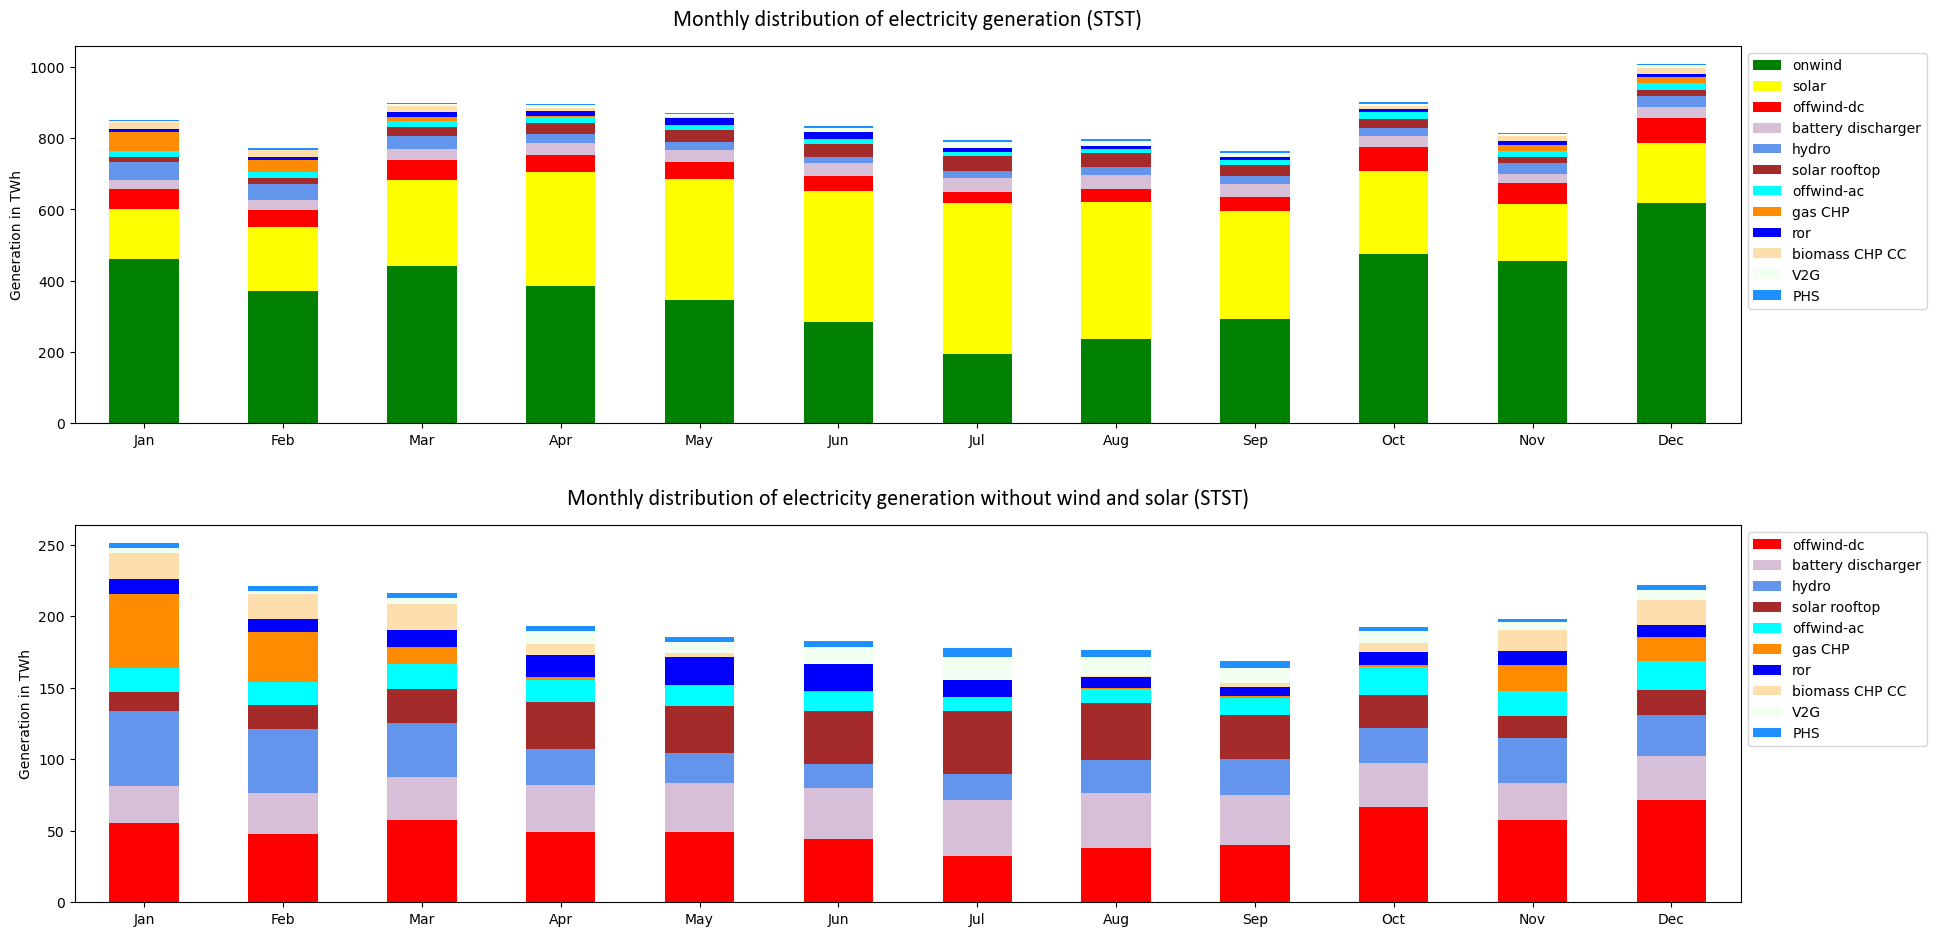

In [100]:
# thesis plot (STST)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(20, 10))

# sort carriers by ouptut and exclude all with less than 40 GW
i_no_gen = res_no_all_pos.sum().sort_values(ascending=False)[res_no_all_pos.sum().sort_values(ascending=False) > 40 * 1e3].index

(res_no_all_pos[i_no_gen]/1000).plot(ax=ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_no_all_pos[i_no_gen].columns])
ax1.legend(ncol=1, bbox_to_anchor=(1, 1))
ax1.set_title("Monthly distribution of electricity generation (STST)", fontsize=16, pad=15,  **font1)
ax1.set_ylabel("Generation in TWh")
ax1.set_xticks(ticks=ax1.get_xticks(), labels=[month[:3] for month in month_list], rotation=0)

# exclude solar and onwind
i_no_gen_ex = i_no_gen.drop(["onwind", "solar"])

(res_no_all_pos[i_no_gen_ex]/1000).plot(ax=ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[i_no_gen_ex].columns])
ax2.legend(ncol=1, bbox_to_anchor=(1, 1))
ax2.set_title("Monthly distribution of electricity generation without wind and solar (STST)", fontsize=16, pad=15,  **font1)
ax2.set_ylabel("Generation in TWh")
ax2.set_xticks(ticks=ax2.get_xticks(), labels=[month[:3] for month in month_list], rotation=0)

fig.tight_layout(pad=3)
fig.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_monthly_STST.png")

In [30]:
# Further investigation
res_no_all_pos[i_no_gen_ex]["gas CHP CC"].loc[["Jan-2013", "Feb-2013"]].sum() / (res_no_all_pos[i_no_gen_ex]["gas CHP CC"].sum() - res_no_all_pos[i_no_gen_ex]["gas CHP CC"].loc[["Jan-2013", "Feb-2013"]].sum())

0.810150056705856

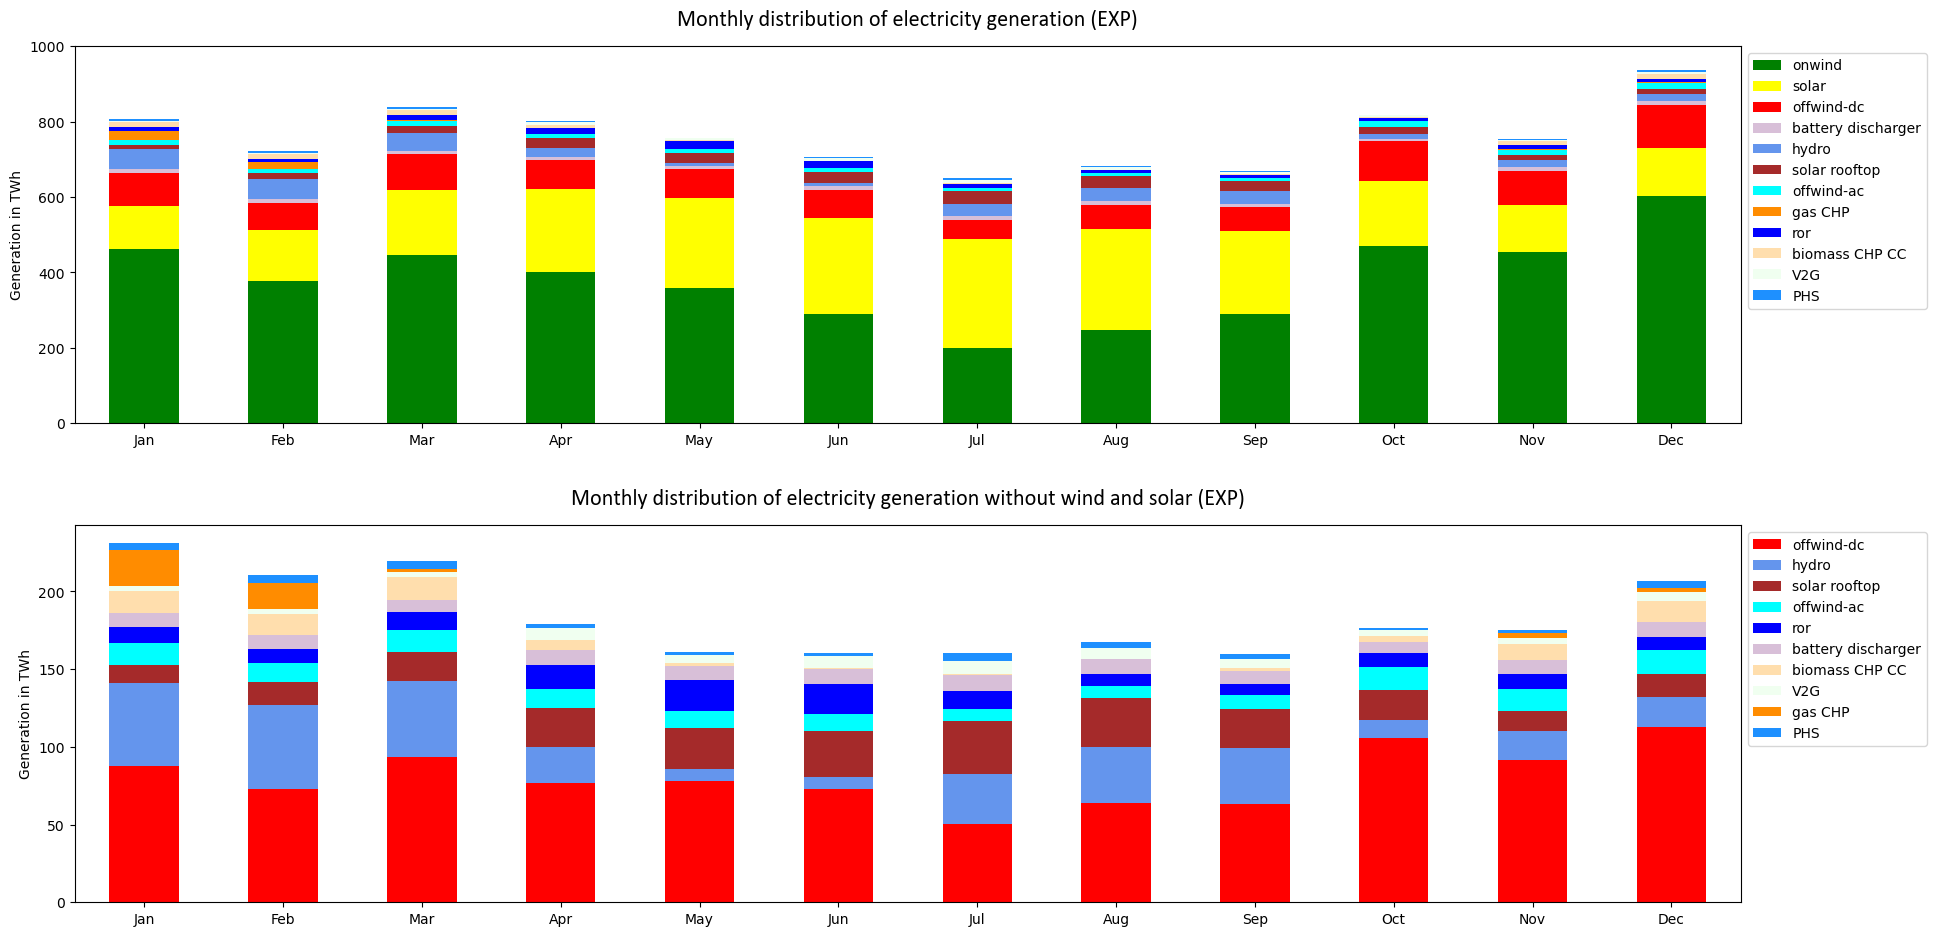

In [102]:
# EXP

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(20, 10))

# sort carriers by ouptut and exclude all with less than 40 GW
i_h2_gen = res_h2_all_pos.sum().sort_values(ascending=False)[res_h2_all_pos.sum().sort_values(ascending=False) > 40 * 1e3].index

(res_h2_all_pos[i_no_gen]/1000).plot(ax=ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_h2_all_pos[i_no_gen].columns])
ax1.legend(ncol=1, bbox_to_anchor=(1, 1))
ax1.set_title("Monthly distribution of electricity generation (EXP)", fontsize=16, pad=15,  **font1)
ax1.set_ylabel("Generation in TWh")
ax1.set_xticks(ticks=ax1.get_xticks(), labels=[month[:3] for month in month_list], rotation=0)
ax1.set_ylim([0,1000])

# exclude solar and onwind
i_h2_gen_ex = i_h2_gen.drop(["onwind", "solar"])

(res_h2_all_pos[i_h2_gen_ex]/1000).plot(ax=ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[i_h2_gen_ex].columns])
ax2.legend(ncol=1, bbox_to_anchor=(1, 1))
ax2.set_title("Monthly distribution of electricity generation without wind and solar (EXP)", fontsize=16, pad=15,  **font1)
ax2.set_ylabel("Generation in TWh")
ax2.set_xticks(ticks=ax2.get_xticks(), labels=[month[:3] for month in month_list], rotation=0)

fig.tight_layout(pad=3)
fig.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_bal_monthly_EXP.png")

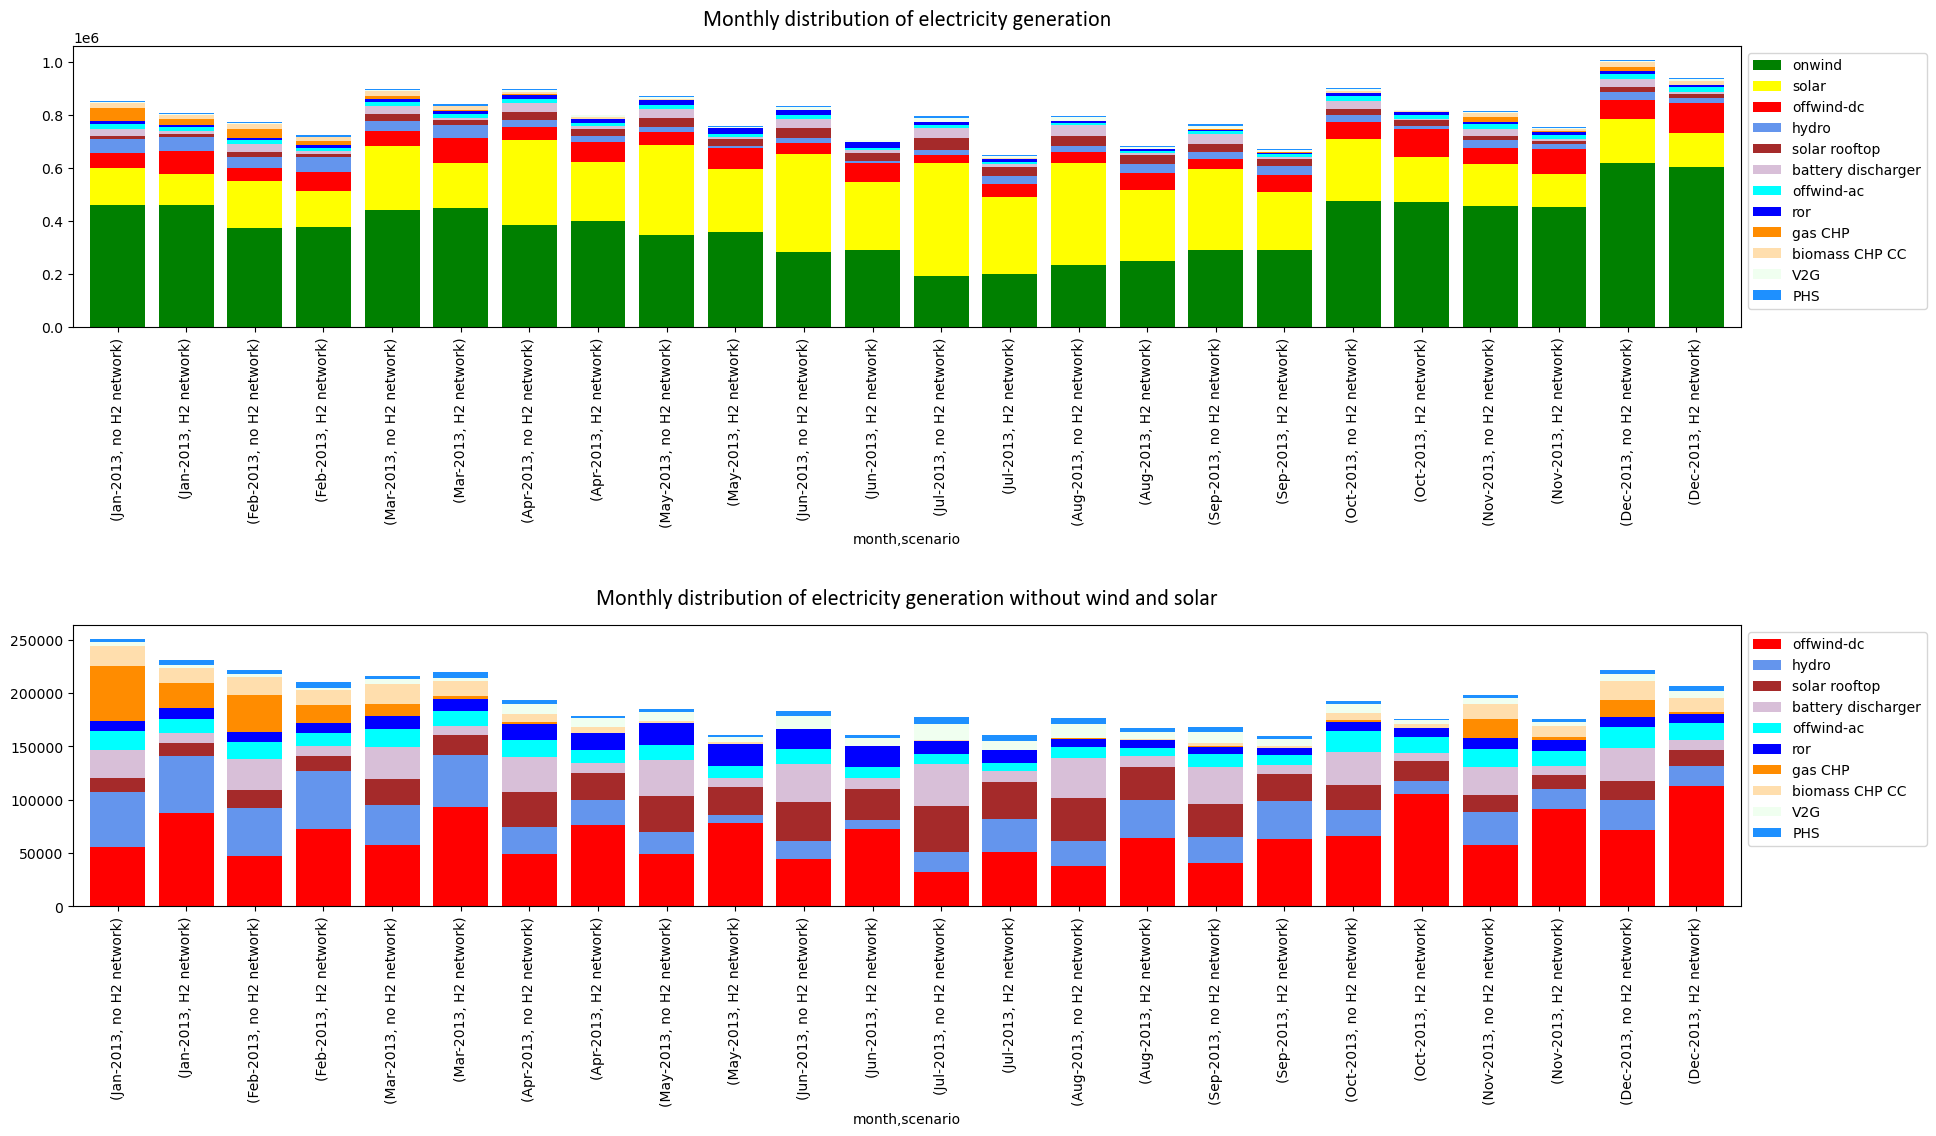

In [82]:
# both scenarios

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(20, 12))

# sort carriers by ouptut and exclude all with less than 40 GWh
index = res_pos.sum().sort_values(ascending=False)[res_pos.sum().sort_values(ascending=False) > 40*1e3].index

res_pos[index].plot(ax=ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[index].columns], width=0.8)
ax1.legend(ncol=1, bbox_to_anchor=(1, 1))
ax1.set_title("Monthly distribution of electricity generation", fontsize=16, pad=15,  **font1)

# exclude solar and onwind
index = index.drop(["onwind", "solar"])

res_pos[index].plot(ax=ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_pos[index].columns], width=0.8)
ax2.legend(ncol=1, bbox_to_anchor=(1, 1))
ax2.set_title("Monthly distribution of electricity generation without wind and solar", fontsize=16, pad=15,  **font1)

fig.tight_layout(pad=3)
fig.show()

In [33]:
# consumption carriers
abs(res_no_all_neg.sum()).sort_values(ascending=False)[abs(res_no_all_neg.sum()).sort_values(ascending=False) > 1].index

Index(['H2 Electrolysis', 'BEV charger', 'heat pump', 'battery charger',
       'resistive heater', 'PHS', 'DAC', 'home battery charger'],
      dtype='object', name='carrier')

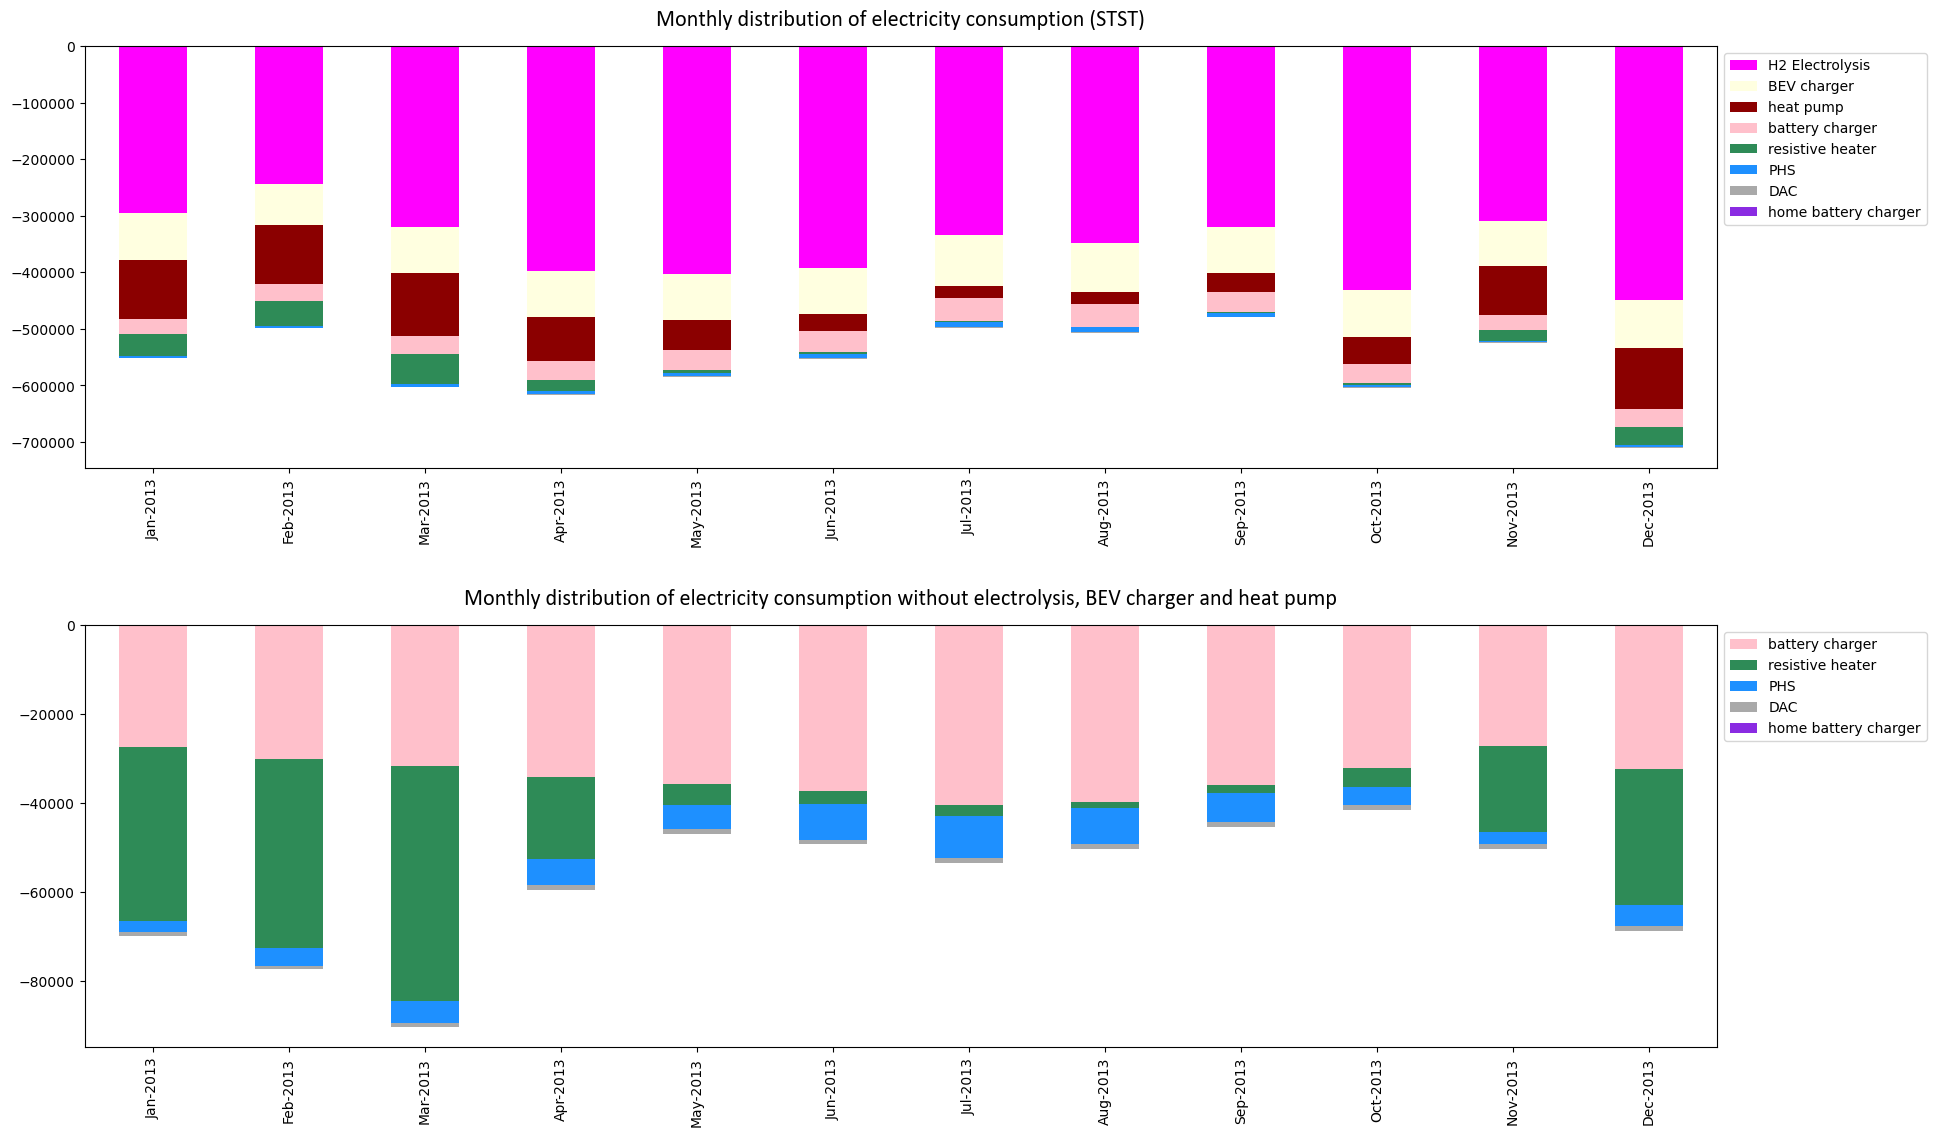

In [34]:
# STST

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(20, 12))

# sort carriers by ouptut and exclude all with less than 1 GW
i_no_con = abs(res_no_all_neg.sum()).sort_values(ascending=False)[abs(res_no_all_neg.sum()).sort_values(ascending=False) > 1].index

res_no_all_neg[i_no_con].plot(ax=ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_no_all_neg[i_no_con].columns])
ax1.legend(ncol=1, bbox_to_anchor=(1, 1))
ax1.set_title("Monthly distribution of electricity consumption (STST)", fontsize=16, pad=15,  **font1)

# exclude
i_no_con_ex = i_no_con.drop(["H2 Electrolysis", "BEV charger", "heat pump"])

res_no_all_neg[i_no_con_ex].plot(ax=ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_no_all_neg[i_no_con_ex].columns])
ax2.legend(ncol=1, bbox_to_anchor=(1, 1))
ax2.set_title("Monthly distribution of electricity consumption without electrolysis, BEV charger and heat pump", fontsize=16, pad=15,  **font1)

fig.tight_layout(pad=3)
fig.show()

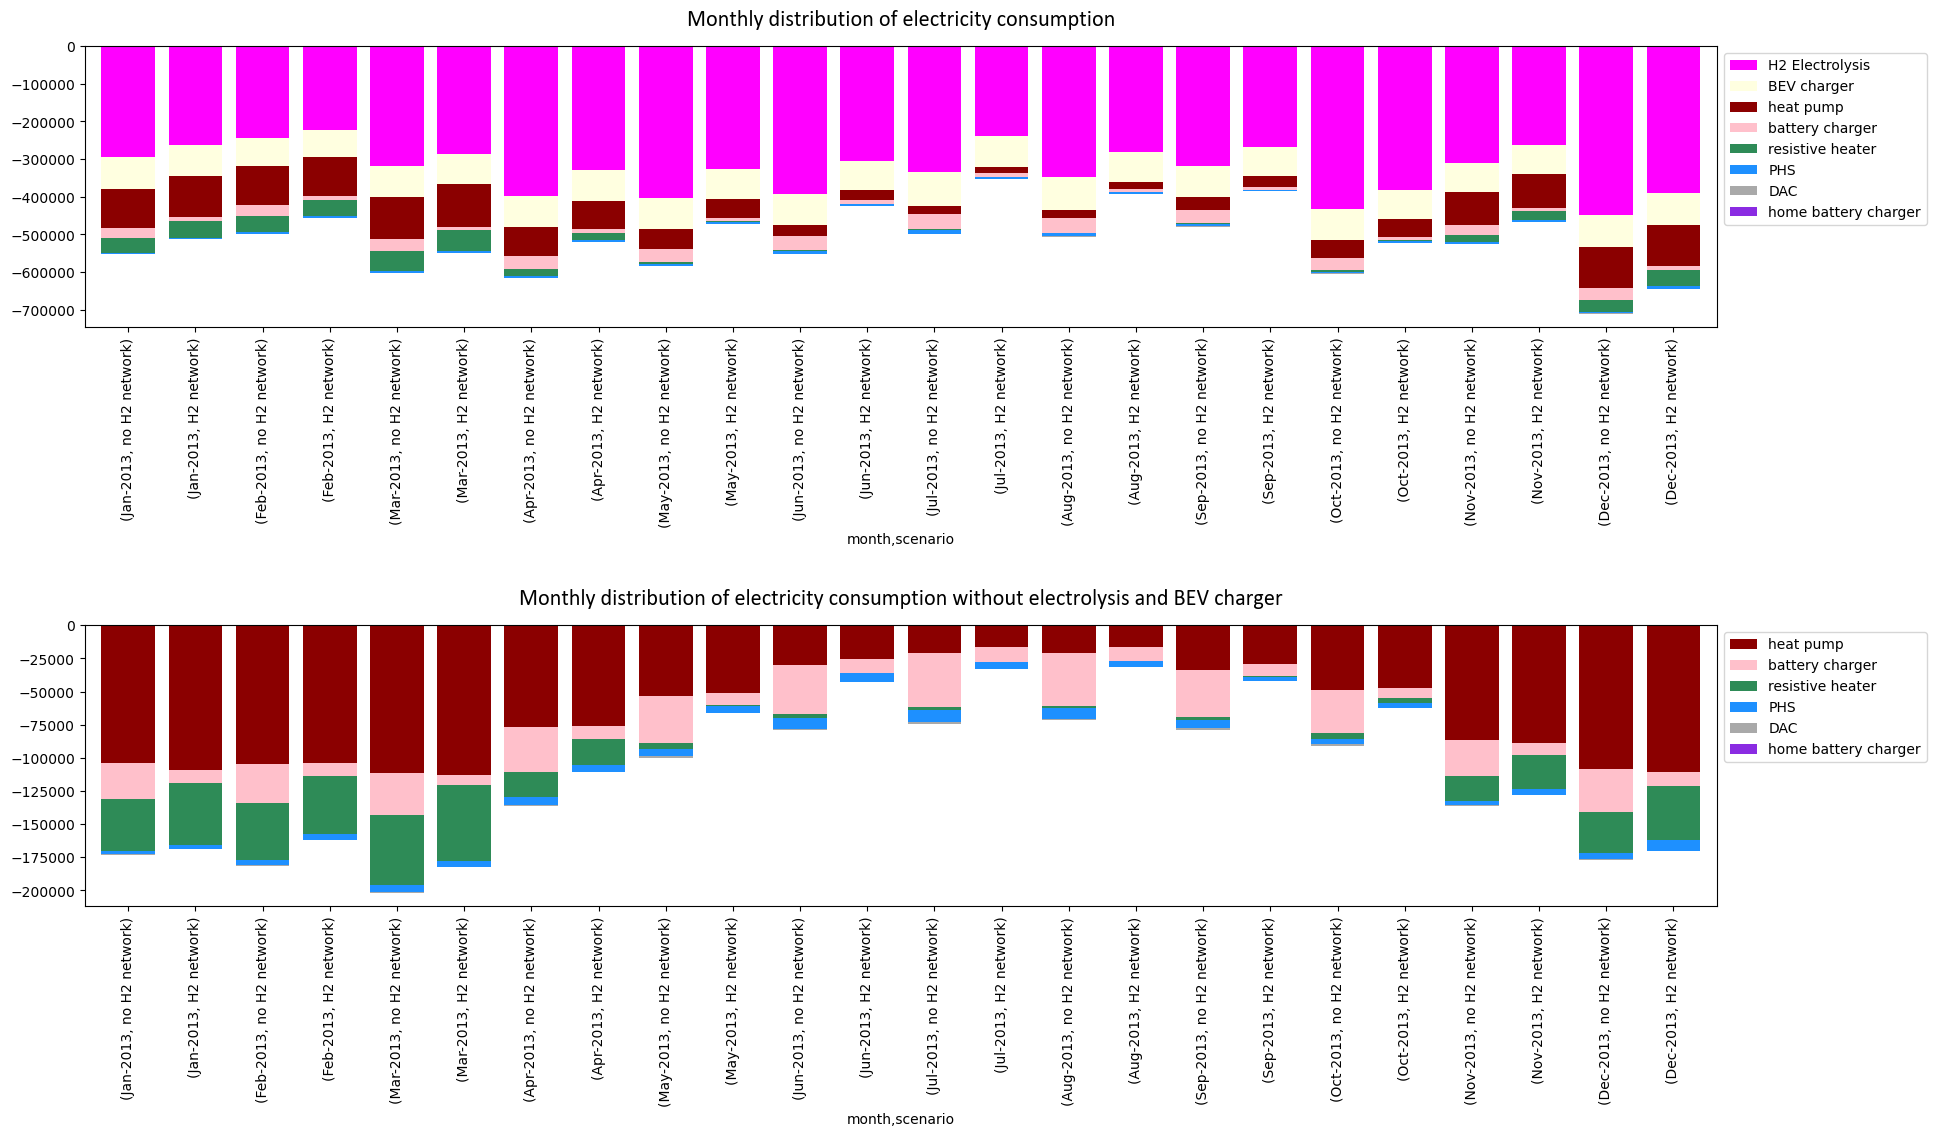

In [35]:
# both

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(20, 12))

# sort carriers by ouptut and exclude all with less than 1 GW
index = abs(res_neg.sum()).sort_values(ascending=False)[abs(res_neg.sum()).sort_values(ascending=False) > 1].index

res_neg[index].plot(ax=ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_neg[index].columns], width=0.8)
ax1.legend(ncol=1, bbox_to_anchor=(1, 1))
ax1.set_title("Monthly distribution of electricity consumption", fontsize=16, pad=15,  **font1)

# exclude
index = index.drop(["H2 Electrolysis", "BEV charger"])

res_neg[index].plot(ax=ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in res_neg[index].columns], width=0.8)
ax2.legend(ncol=1, bbox_to_anchor=(1, 1))
ax2.set_title("Monthly distribution of electricity consumption without electrolysis and BEV charger", fontsize=16, pad=15,  **font1)

fig.tight_layout(pad=3)
fig.show()

## Focus on technologies

In [36]:
n.generators_t.p.loc[:, (n.generators.carrier == "onwind") | (n.generators.carrier == "solar")]

Generator            AL0 0 onwind   AL0 0 solar  AT0 0 onwind  AT0 0 solar  \
snapshot                                                                     
2013-01-01 00:00:00      0.000000      0.000000   4917.113011     0.000000   
2013-01-01 03:00:00      0.000000      0.000000   4623.535568     0.000000   
2013-01-01 06:00:00      0.000000   4795.128080   3455.948969   792.324661   
2013-01-01 09:00:00      0.000000  11509.646090   1471.522842  2989.259557   
2013-01-01 12:00:00      0.000000   6377.253396    497.291894  1678.141986   
...                           ...           ...           ...          ...   
2013-12-31 09:00:00      0.000000   4911.200758    448.489909  1048.040739   
2013-12-31 12:00:00      0.000000   2989.734046   1290.876086   710.217489   
2013-12-31 15:00:00      0.000000      0.000000   1932.721807     0.000000   
2013-12-31 18:00:00      0.000551      0.000000   3046.962171     0.000000   
2013-12-31 21:00:00      0.000649      0.000000   3613.135660     0.000000   

Generator            AT0 1 onwind  AT0 1 solar  AT0 2 onwind   AT0 2 solar  \
snapshot                                                                     
2013-01-01 00:00:00      0.000160     0.000000      0.000317      0.000000   
2013-01-01 03:00:00      0.000105     0.000000      0.000000      0.000000   
2013-01-01 06:00:00      0.000061  1207.124091      0.000000   3648.126751   
2013-01-01 09:00:00      0.000000  5691.630927      0.000000  17190.506061   
2013-01-01 12:00:00      0.000000  4162.664607      0.000000  10963.896984   
...                           ...          ...           ...           ...   
2013-12-31 09:00:00      0.000000  4358.484623      0.000000  11081.941443   
2013-12-31 12:00:00      0.000000  2908.464725      0.000000   7371.530007   
2013-12-31 15:00:00      0.000000     0.000000      0.000000      0.000000   
2013-12-31 18:00:00      0.000000     0.000000      0.000676      0.000000   
2013-12-31 21:00:00      0.000088     0.000000      0.000521      0.000000   

Generator            BA0 0 onwind  BA0 0 solar  ...  SE3 5 onwind  \
snapshot                                        ...                 
2013-01-01 00:00:00           0.0     0.000000  ...      0.009930   
2013-01-01 03:00:00           0.0     0.000000  ...      0.006851   
2013-01-01 06:00:00           0.0  2163.155608  ...      0.003427   
2013-01-01 09:00:00           0.0  6556.602548  ...      0.002262   
2013-01-01 12:00:00           0.0  3854.296060  ...      0.001043   
...                           ...          ...  ...           ...   
2013-12-31 09:00:00           0.0  2405.977669  ...      0.047624   
2013-12-31 12:00:00           0.0  1331.959089  ...      0.044853   
2013-12-31 15:00:00           0.0     0.000000  ...      0.031277   
2013-12-31 18:00:00           0.0     0.000000  ...      0.021597   
2013-12-31 21:00:00           0.0     0.000000  ...      0.012569   

Generator            SE3 5 solar  SE3 6 onwind  SE3 6 solar  SE3 7 onwind  \
snapshot                                                                    
2013-01-01 00:00:00          0.0   3853.975032     0.000000      0.018161   
2013-01-01 03:00:00          0.0   3520.456123     0.000000      0.017416   
2013-01-01 06:00:00          0.0   2849.870100     0.000000      0.024743   
2013-01-01 09:00:00          0.0   1927.536014  2301.055350      0.019145   
2013-01-01 12:00:00          0.0   1374.008866   527.732840      0.013911   
...                          ...           ...          ...           ...   
2013-12-31 09:00:00          0.0   4166.463368   257.691648      0.009419   
2013-12-31 12:00:00          0.0   3814.872374     0.000000      0.024671   
2013-12-31 15:00:00          0.0   2782.503953     0.000000      0.036083   
2013-12-31 18:00:00          0.0   1879.492713     0.000000      0.036583   
2013-12-31 21:00:00          0.0   1336.698562     0.000000      0.026737   

Generator            SE3 7 solar  SI0 0 onwind  SI0 0 solar  SK0 0 onw

### Load Duration curves

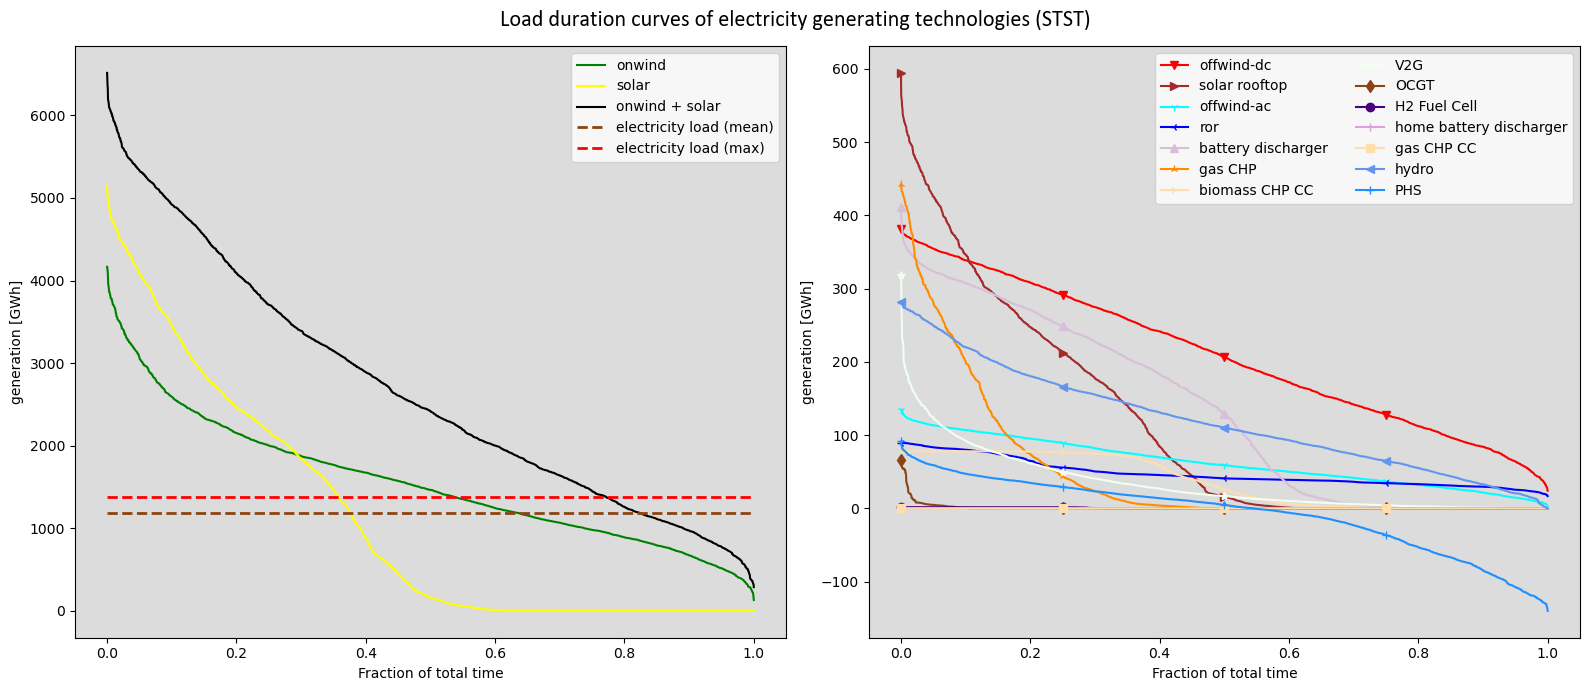

In [37]:
# thesis plot

# STST
n = n_no

# reverse renaming to find all carriers in network
i_no_gen_ex_rev = [carrier_renaming_reverse.get(n, n) for n in i_no_gen_ex]
index = list(i_no_gen_ex_rev)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))

for c in ["onwind", "solar"]:
    gen = (n.generators_t.p.loc[:, n.generators.carrier == c] / 1000)*3
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax1.plot(gen, color = carrier_colors[c], label=c)

# plot solar + onwind
gen = (n.generators_t.p.loc[:, (n.generators.carrier == "onwind") | (n.generators.carrier == "solar")] / 1000)*3
gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
ax1.plot(gen, color = "black", label= "onwind + solar")

# plot load
load = (n_no.loads_t.p.loc[: , n_no.loads.carrier.isin(["electricity", "industry electricity", "agriculture electricity"])].sum(axis=1) / 1000) * 3
ax1.hlines(y=load.mean(), xmin=0, xmax=1, ls="dashed", linewidth=2, color='saddlebrown', label="electricity load (mean)")
ax1.hlines(y=load.max(), xmin=0, xmax=1, ls="dashed", linewidth=2, color='red', label = "electricity load (max)")

ax1.set_ylabel("generation [GWh]")
ax1.set_xlabel("Fraction of total time")
ax1.set_facecolor("gainsboro")
ax1.legend()

for c in c_gen(index, n_no):
    if c == "":
        continue
    gen = (n.generators_t.p.loc[:, n.generators.carrier == c] / 1000)*3
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

for c in c_link(index, n_no):
    gen = (-n.links_t.p1.loc[:, n.links.carrier == c] / 1000)*3
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c.replace("urban central solid ", "").replace("urban central ", ""),marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

for c in c_su(index, n_no):
    gen = (n.storage_units_t.p.loc[:, n.storage_units.carrier == c] / 1000)*3
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

ax2.set_ylabel("generation [GWh]")
ax2.set_xlabel("Fraction of total time")
ax2.set_facecolor("gainsboro")
ax2.legend(ncol=2)

fig.suptitle("Load duration curves of electricity generating technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/load_dur_gen_STST.png")

1187.7221435887188

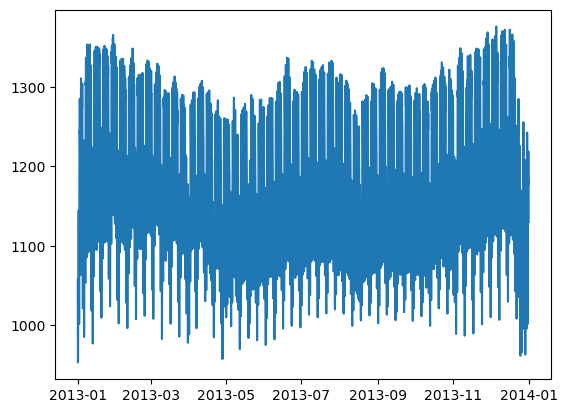

In [38]:
load = (n_no.loads_t.p.loc[: , n_no.loads.carrier.isin(["electricity", "industry electricity", "agriculture electricity"])].sum(axis=1) / 1000) * 3
plt.plot(load)
load.mean()

In [39]:
c = "OCGT"
gen = (-n.links_t.p1.loc[:, n.links.carrier == c] / 1000)*3
gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
gen

0
0.000000  66.677052
0.000343  65.541053
0.000685  60.916631
0.001028  58.146101
0.001370  56.882450
...             ...
0.998630   0.000504
0.998972   0.000503
0.999315   0.000499
0.999657   0.000486
1.000000   0.000486

[2920 rows x 1 columns]

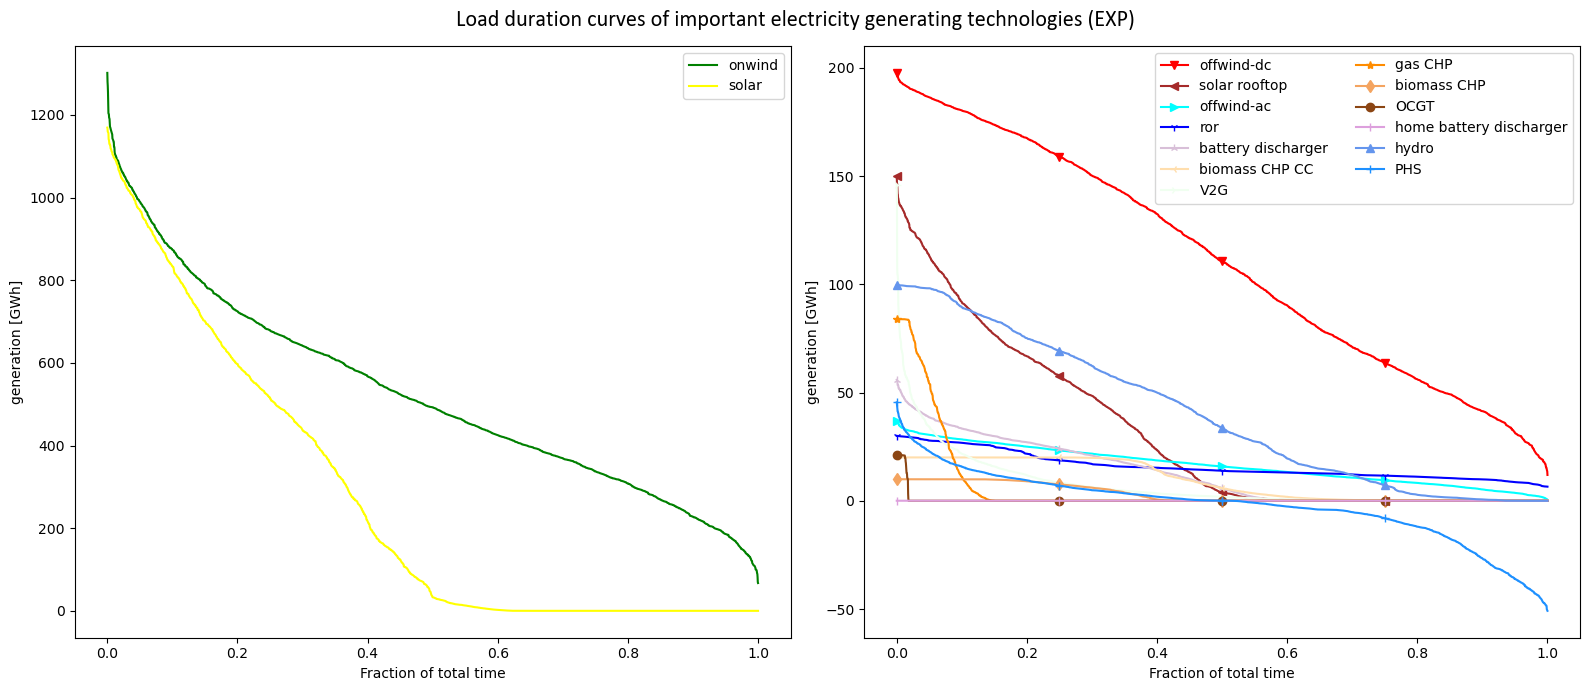

In [40]:
# EXP
n = n_h2

# reverse renaming to find all carriers in network
i_h2_gen_ex_rev = [carrier_renaming_reverse.get(n, n) for n in i_h2_gen_ex]
index = list(i_h2_gen_ex_rev)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))

for c in ["onwind", "solar"]:
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax1.plot(gen, color = carrier_colors[c], label=c)

ax1.set_ylabel("generation [GWh]")
ax1.set_xlabel("Fraction of total time")
ax1.legend()

for c in c_gen(index, n_no):
    if c == "":
        continue
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

for c in c_link(index, n_no):
    gen = -n.links_t.p1.loc[:, n.links.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c.replace("urban central solid ", "").replace("urban central ", ""), marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

for c in c_su(index, n_no):
    gen = n.storage_units_t.p.loc[:, n.storage_units.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

ax2.set_ylabel("generation [GWh]")
ax2.set_xlabel("Fraction of total time")
ax2.legend(ncol=2)

fig.suptitle("Load duration curves of important electricity generating technologies (EXP)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/load_dur_gen_EXP.png")

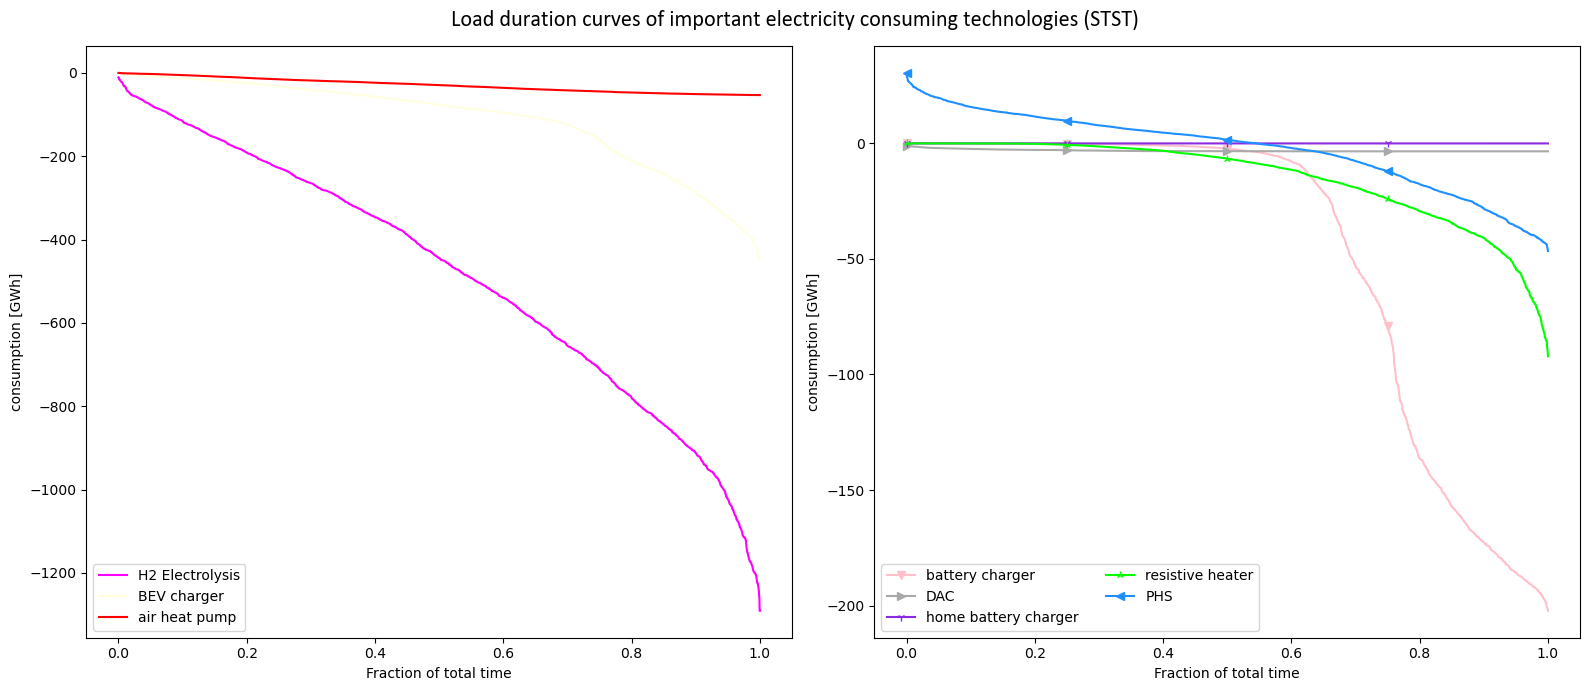

In [41]:
# STST consumption
n = n_no

# reverse renaming to find all carriers in network
i_no_gen_ex_rev = [carrier_renaming_reverse.get(n, n) for n in i_no_gen_ex]
index = list(i_no_gen_ex_rev)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))

index = ["H2 Electrolysis", "BEV charger"] + ["urban central air heat pump"] #heat_pump # heat pump is missing due to grouping

for c in c_gen(index, n_no):
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax1.plot(gen, color = carrier_colors[c], label=c)

for c in c_link(index, n_no):
    gen = -n.links_t.p0.loc[:, n.links.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax1.plot(gen, color = carrier_colors[c], label=c.replace("urban central solid ", "").replace("urban central ", ""))

ax1.set_ylabel("consumption [GWh]")
ax1.set_xlabel("Fraction of total time")
ax1.legend(loc="lower left")

index = list(i_no_con_ex) + ["urban central resistive heater"] #resistive_heater # resistive heater is missing due to grouping

for c in c_gen(index, n_no):
    gen = n.generators_t.p.loc[:, n.generators.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

for c in c_link(index, n_no):
    gen = -n.links_t.p0.loc[:, n.links.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c.replace("urban central solid ", "").replace("urban central ", ""), marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

for c in c_su(index, n_no):
    gen = n.storage_units_t.p.loc[:, n.storage_units.carrier == c] / 1000
    gen = pd.DataFrame(gen.sum(axis=1).sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
    ax2.plot(gen, color = carrier_colors[c], label=c, marker=markers[index.index(c)], markevery=[0,int(0.25*2920), int(0.5*2920),int(0.75*2920)-1])

ax2.set_ylabel("consumption [GWh]")
ax2.set_xlabel("Fraction of total time")
ax2.legend(loc="lower left", ncol=2)

fig.suptitle("Load duration curves of important electricity consuming technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/load_dur_con_STST.png")

Questions:
- Does it make more sense for the consuming carriers to look at p0 or p1? just difference in magnitude and sign

Findings

### Capacity factors

**Question:**
- You have to aggregate over two dimensions: space and time
- Which dimension makes more sense to aggregate over
- You could visualize space coponent via map or boxplot
- You could visualize time component via heatmap

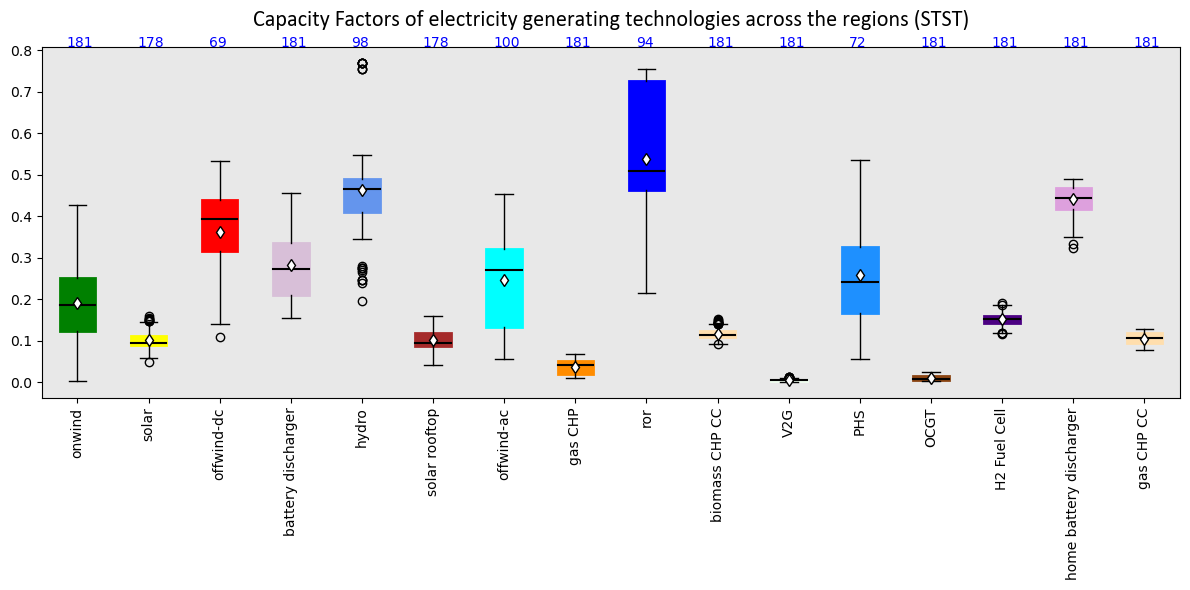

In [42]:
# capacity factors across regions as boxplot

boxprops=dict(facecolor="white", color="white")
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}

i_no_gen_rev = [carrier_renaming_reverse.get(n, n) for n in i_no_gen]
df = df_no_ons[[f"{i}_cf" for i in i_no_gen_rev]]
df = df.values

# Filter data using np.isnan
mask = ~np.isnan(df)
filtered_data = [d[m] for d, m in zip(df.T, mask.T)]

fig, ax = plt.subplots(figsize=(12, 6))
bp = plt.boxplot(x=filtered_data, labels =i_no_gen, patch_artist=True, showmeans=True, boxprops=boxprops, meanprops=meanprops, medianprops=medianprops)

for box, col in zip(bp['boxes'],[carrier_colors[c] for c in i_no_gen]):
    # change outline color
    box.set(color=col, linewidth=2)

for i, sample_size in enumerate(df_no_ons[[f"{i}_cf" for i in i_no_gen_rev]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/16,1), textcoords='axes fraction', color="blue")

ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)
plt.xticks(rotation=90)
plt.title("Capacity Factors of electricity generating technologies across the regions (STST)", fontsize=16, pad=15,  **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/cap_fac_el_gen_STST.png")

# diamond indicates the mean (rest is like in normal boxplot)

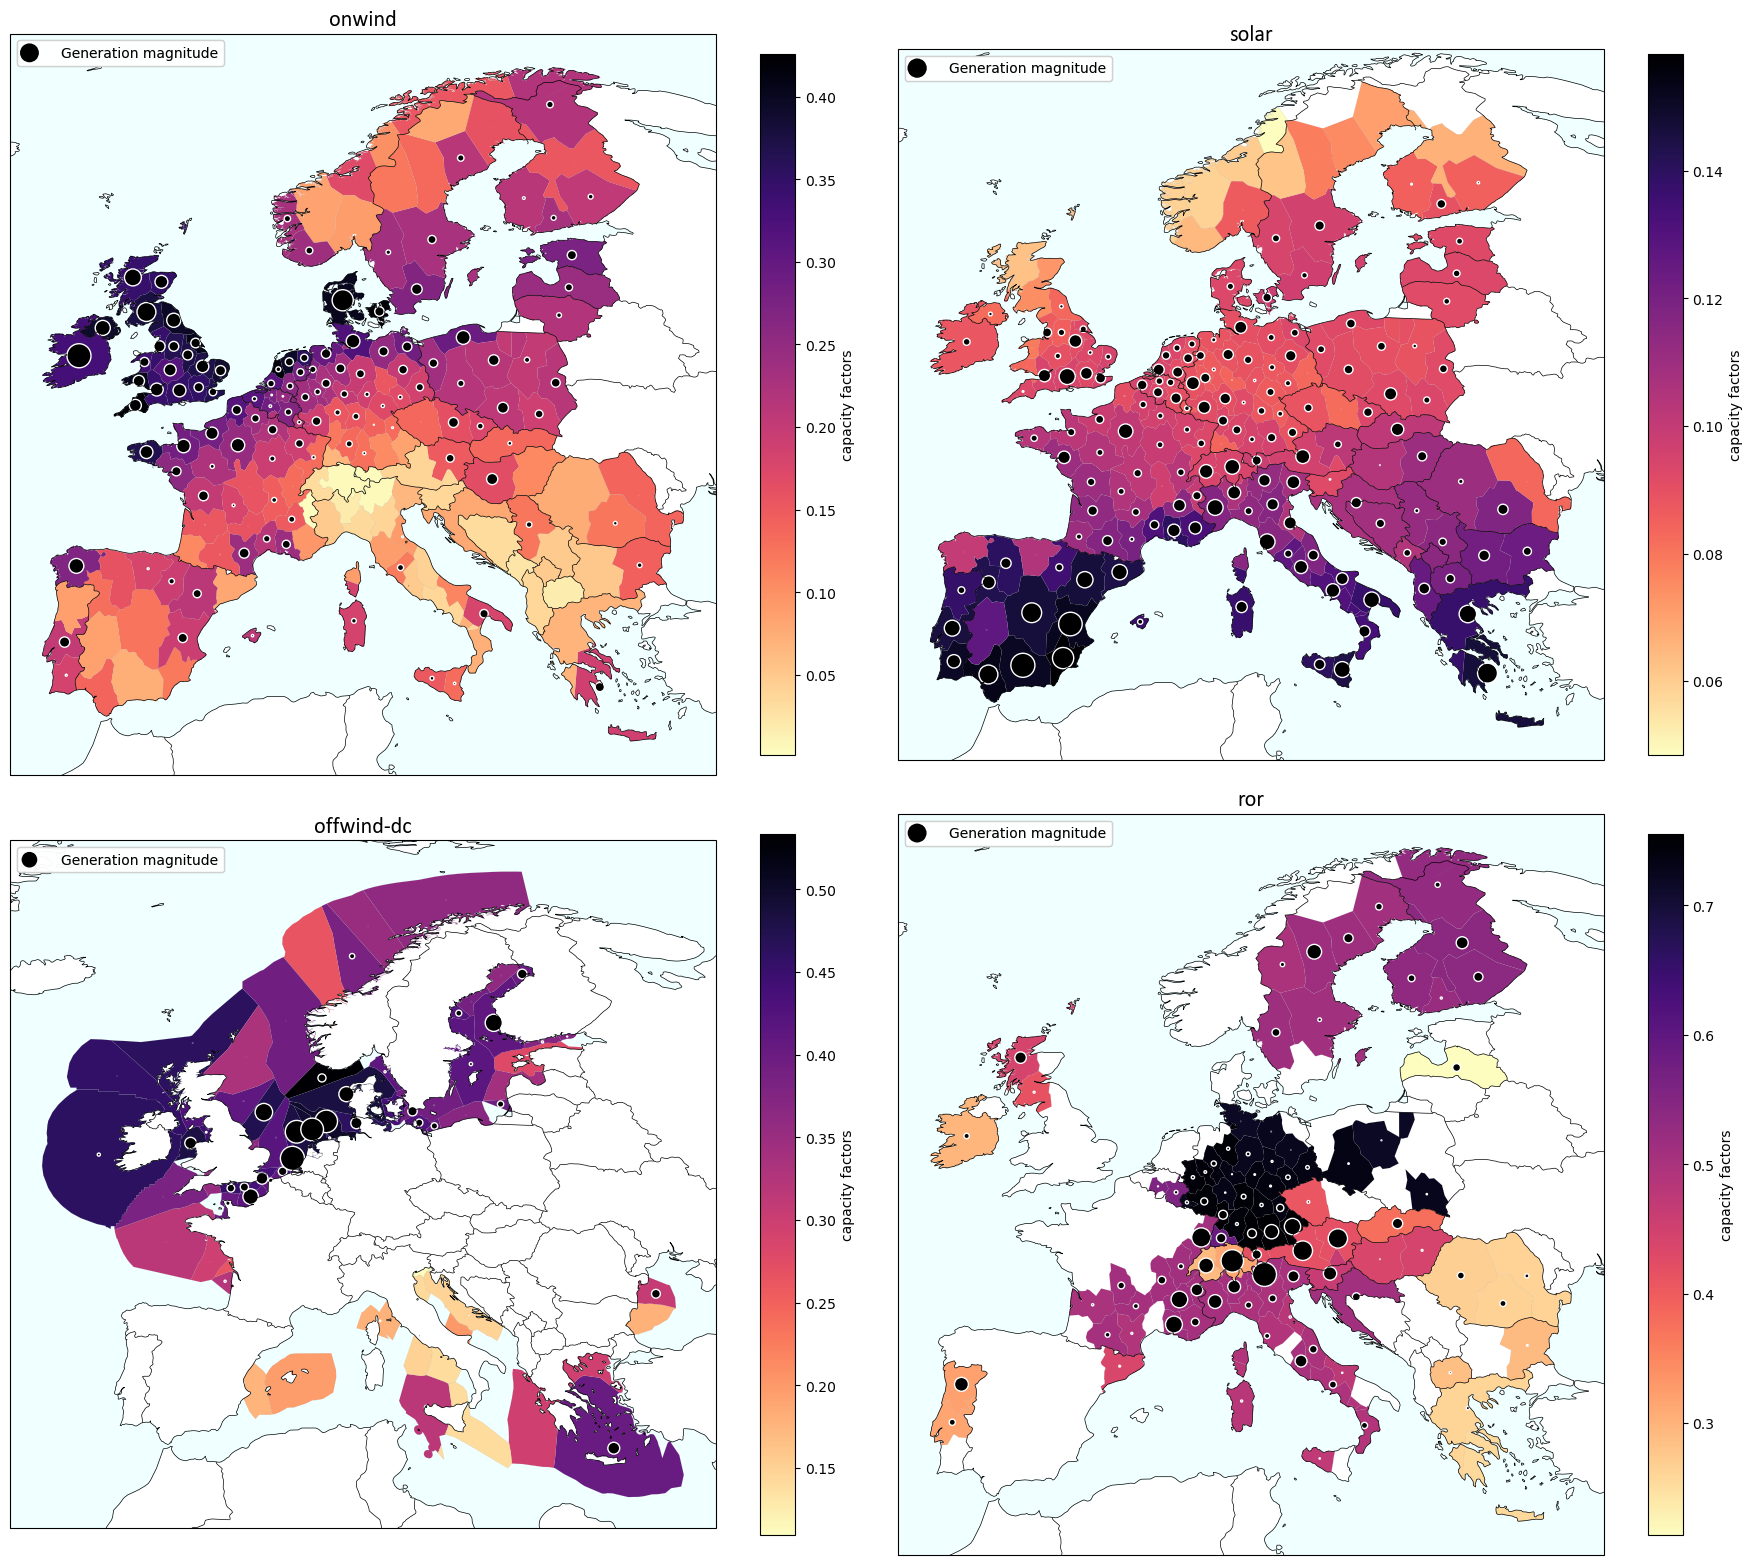

In [43]:
# thesis plot

# capacity factors across regions as map
carriers = ["onwind", "solar","offwind-dc", "ror"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_no_off
    else:
        df = df_no_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_cf",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"capacity factors",
                            'orientation': "vertical",
                                      'shrink' : 0.9})

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/cap_fac_el_gen_vre_STST.png")

# Backup
#m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", bus_sizes=df[f"{carriers[i]}_gen"] / max_size, line_widths=0, link_widths=0)

In [44]:
carrier = "ror"
# correlation capacity factors and generation
df_no_ons[f"{carrier}_cf"].corr(df_no_ons[f"{carrier}_gen"])

-0.196188993945747

In [45]:
# correlation with latitude
latitudes = pd.DataFrame([Point(coords).y for coords in df_no_ons['coords']], index=df_no_ons.index)
df_no_ons[f"{carrier}_cf"].corr(latitudes[0])

0.28699573051012384

In [46]:
df_no_ons[f"{carrier}_gen"].sort_values(ascending=False)

name
IT0 5     11310.501570
CH0 1      9847.982553
AT0 2      7446.952294
AT0 0      7273.786984
FR0 21     7161.141616
              ...     
PT0 2              NaN
RS0 0              NaN
RS0 1              NaN
SE3 3              NaN
SE3 4              NaN
Name: ror_gen, Length: 181, dtype: float64

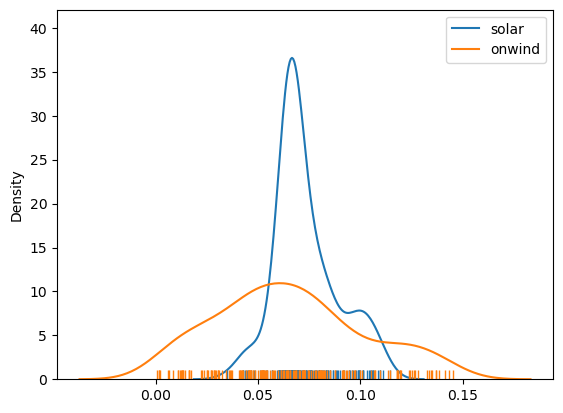

In [47]:
from sklearn import preprocessing

sns.distplot(preprocessing.normalize(df_no_ons["solar_cf"].dropna().values.reshape(1, -1)), hist=False, rug=True, label="solar")
sns.distplot(preprocessing.normalize(df_no_ons["onwind_cf"].dropna().values.reshape(1, -1)), hist=False, rug=True, label="onwind")

plt.legend()
plt.show()

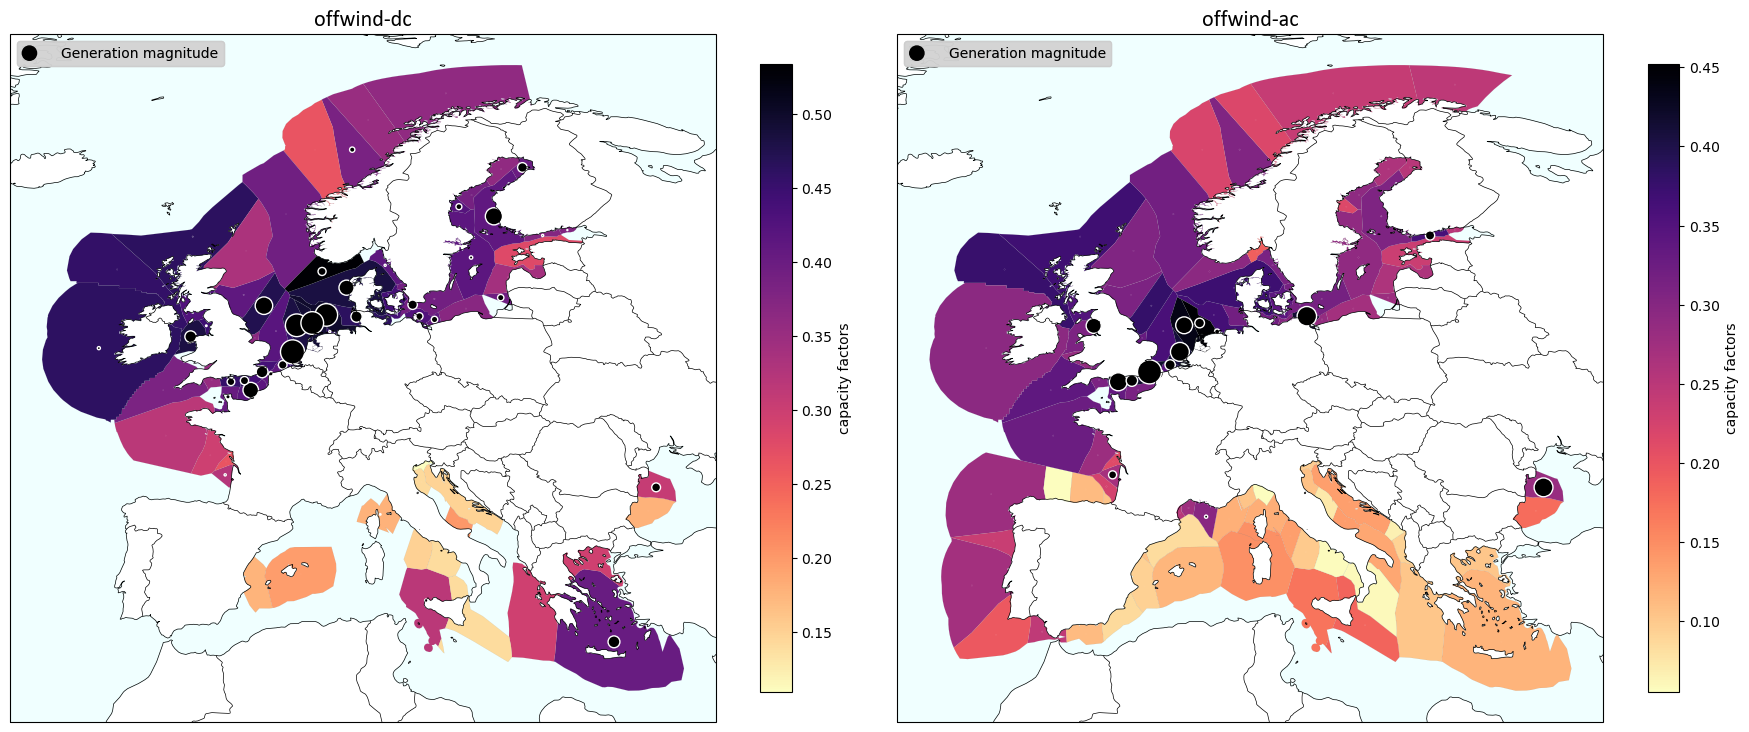

In [48]:
# capacity factors across regions as map
carriers = ["offwind-dc", "offwind-ac"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_no_off
    else:
        df = df_no_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_cf",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"capacity factors",
                            'orientation': "vertical",
                                      'shrink' : 0.4})

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left', 'facecolor': 'lightgrey'})

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)
fig.tight_layout()
plt.show()

# Backup
#m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", bus_sizes=df[f"{carriers[i]}_gen"] / max_size, line_widths=0, link_widths=0)

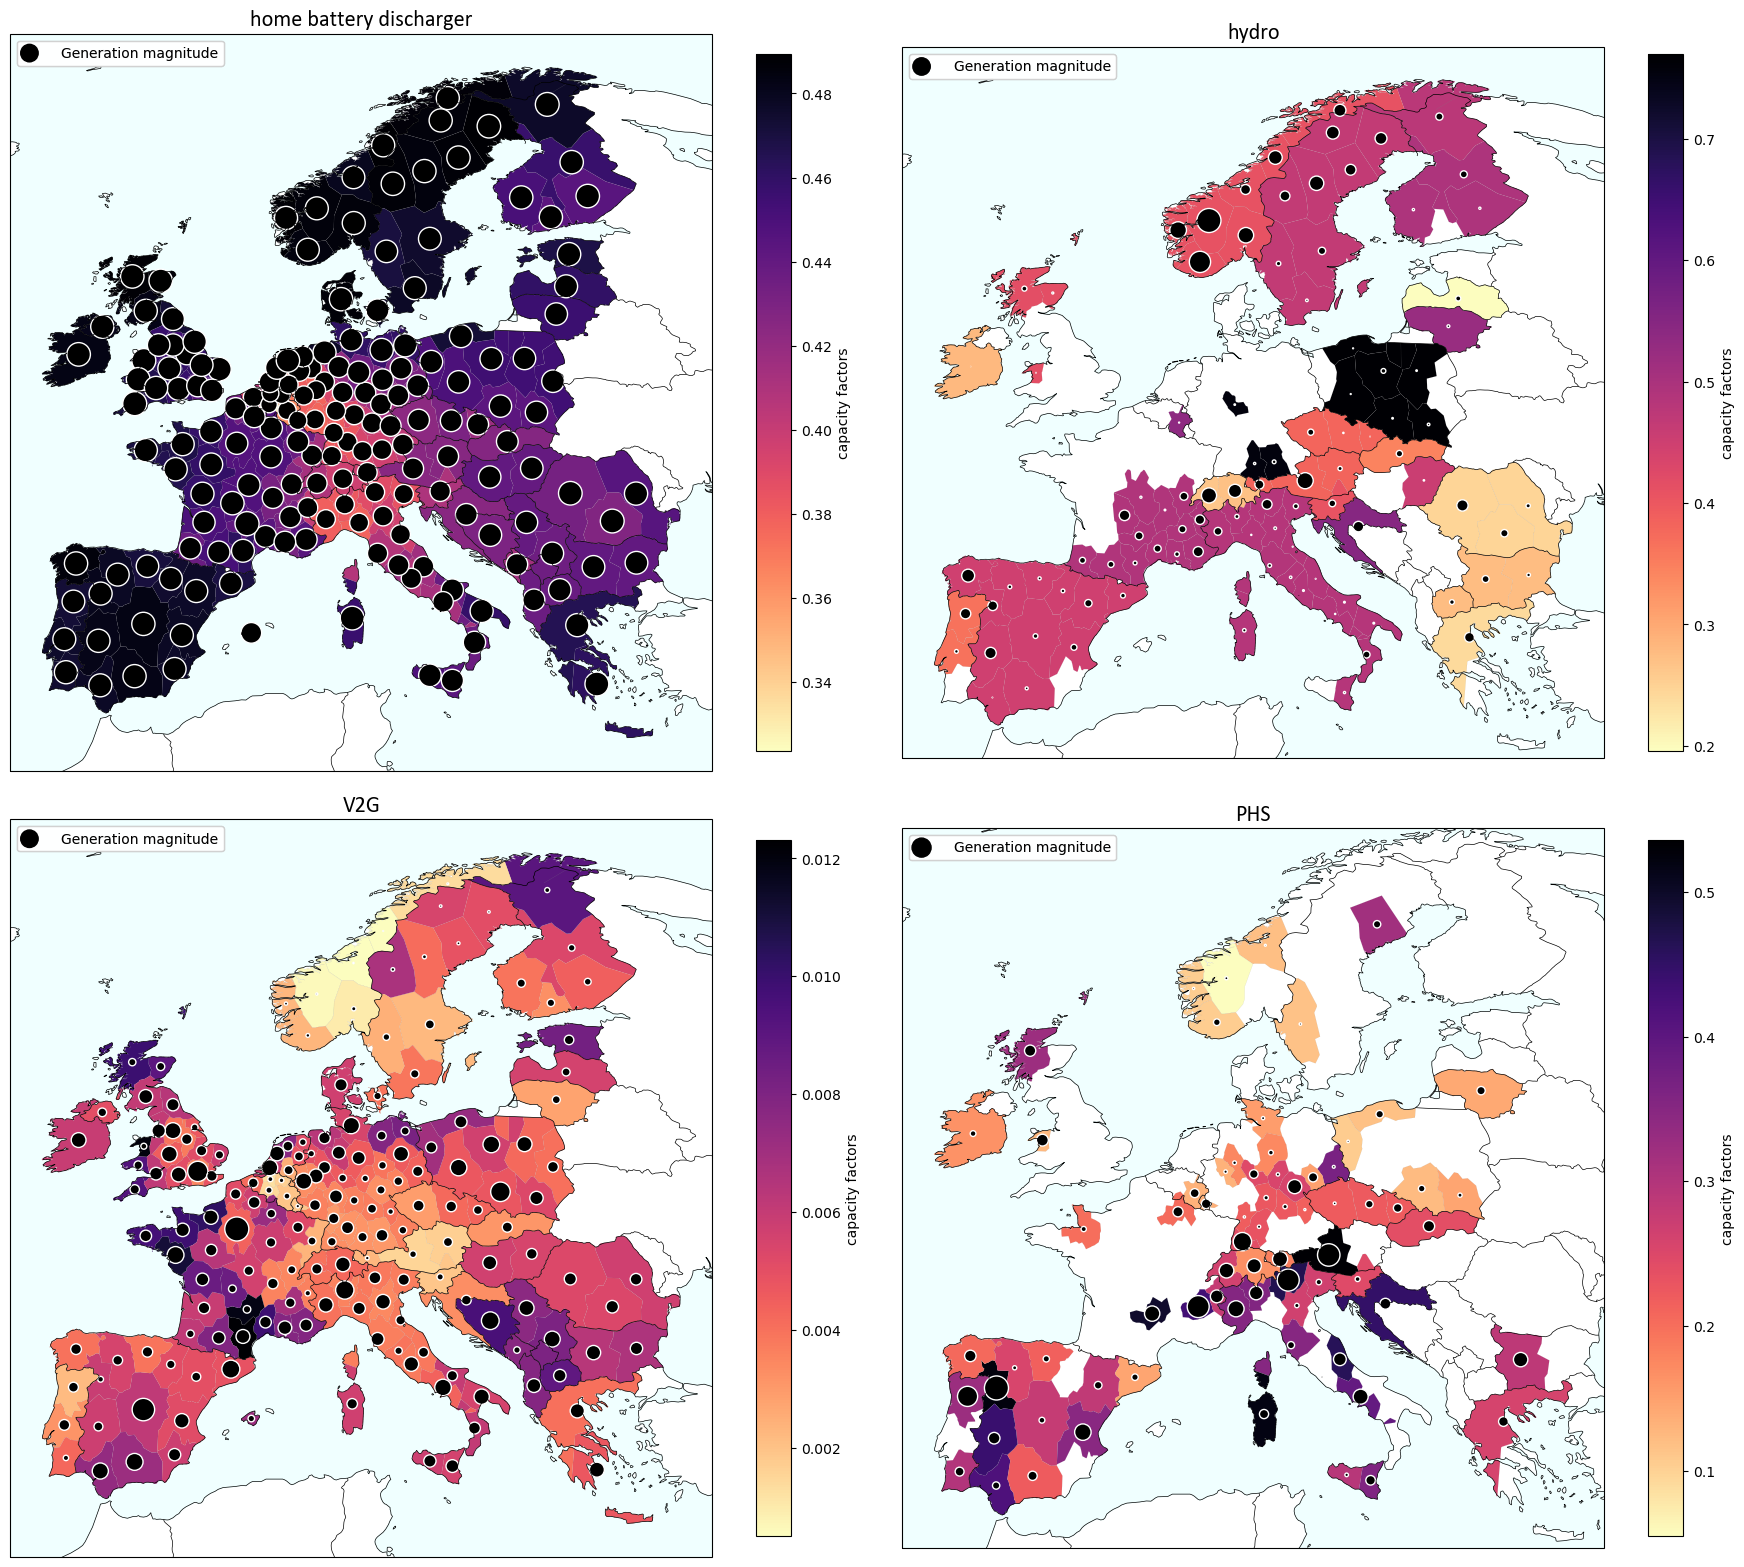

In [49]:
#

# capacity factors across regions as map
carriers = ["home battery discharger", "hydro", "V2G", "PHS"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_no_off
    else:
        df = df_no_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_cf",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"capacity factors",
                            'orientation': "vertical",
                                      'shrink' : 0.9})

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/cap_fac_el_gen_store_STST.png")

# Backup
#m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", bus_sizes=df[f"{carriers[i]}_gen"] / max_size, line_widths=0, link_widths=0)

In [50]:
carrier = "home battery discharger"
df_no_ons[f"{carrier}_gen"].describe()

count    181.000000
mean       0.964604
std        0.130705
min        0.548020
25%        0.880634
50%        1.011260
75%        1.064613
max        1.155360
Name: home battery discharger_gen, dtype: float64

In [51]:
0.385120 / 0.182673

2.1082480716909453

In [52]:
# generation weighted capacity factor
carrier = "home battery discharger"
((df_no_ons[f"{carrier}_gen"] / df_no_ons[f"{carrier}_gen"].sum()) * df_no_ons[f"{carrier}_cf"]).sum()

0.4444997012626182

In [53]:
# Norway indices
no_i = df_no_ons[f"{carrier}_gen"].index[df_no_ons[f"{carrier}_gen"].index.str.contains('NO')]

carrier = "PHS"
df_no_ons[f"{carrier}_gen"].sort_values(ascending=False)

name
ES0 10    4221.366772
AT0 2     3680.427934
IT0 5     3550.129838
FR0 13    3527.596729
PT0 1     2959.409669
             ...     
SE3 2             NaN
SE3 3             NaN
SE3 4             NaN
SE3 5             NaN
SE3 7             NaN
Name: PHS_gen, Length: 181, dtype: float64

In [54]:
df_no_ons[f"{carrier}_gen"][no_i].sum() / df_no_ons[f"{carrier}_gen"].sum()

0.00788781762666158

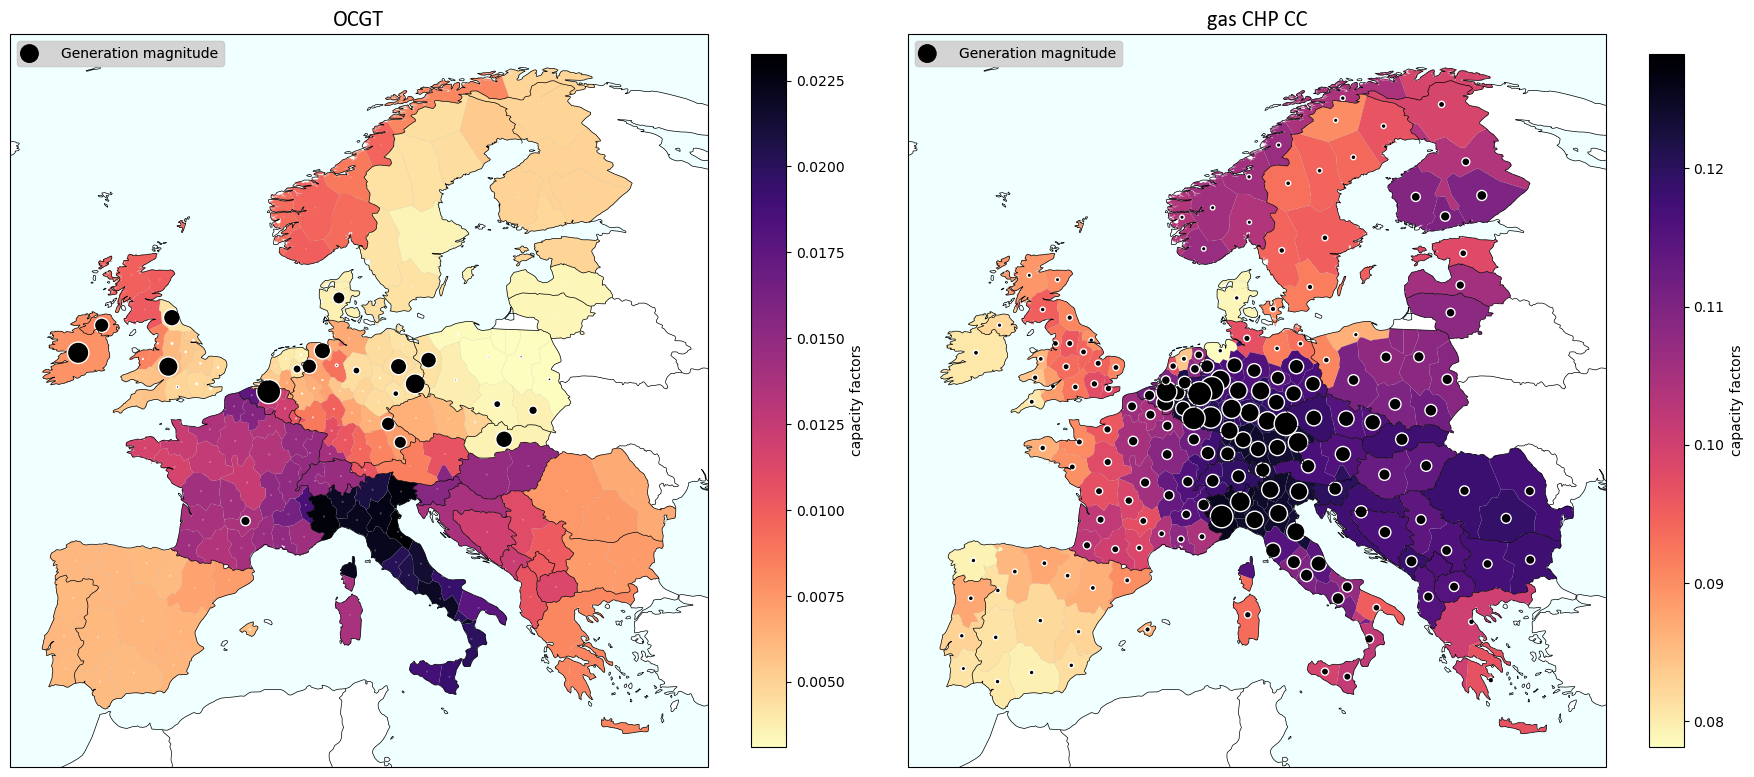

In [55]:
# capacity factors across regions as map
carriers = ["OCGT", "urban central gas CHP CC" ]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 8))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_no_off
    else:
        df = df_no_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_cf",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"capacity factors", 'orientation': "vertical", 'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left', 'facecolor': 'lightgrey'})

    ax.set_title(carriers[i].replace("urban central solid ", "").replace("urban central ", ""), fontsize=16, **font1)
fig.tight_layout()
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/cap_fac_el_gen_peak_STST.png")

In [56]:
c = 'urban central gas CHP CC' # "H2 Fuel Cell" # 'urban central gas CHP CC'
df_no_ons[f"{c}_gen"].sort_values(ascending=False)#[df_no_ons[f"{c}_gen"].sort_values(ascending=False) > 3]

name
DE0 7     0.541202
DE0 26    0.528060
DE0 25    0.518303
LU0 0     0.482706
IT0 12    0.478005
            ...   
NO3 6     0.018372
NO3 4     0.018230
GB5 8     0.017819
PT0 2     0.017588
GB5 0     0.017521
Name: urban central gas CHP CC_gen, Length: 181, dtype: float64

In [57]:
# generation weighted capacity factor
carrier = "H2 Fuel Cell" #urban central solid biomass CHP CC' #"urban central gas CHP"
((df_no_ons[f"{carrier}_gen"] / df_no_ons[f"{carrier}_gen"].sum()) * df_no_ons[f"{carrier}_cf"]).sum()

0.14515237224934022

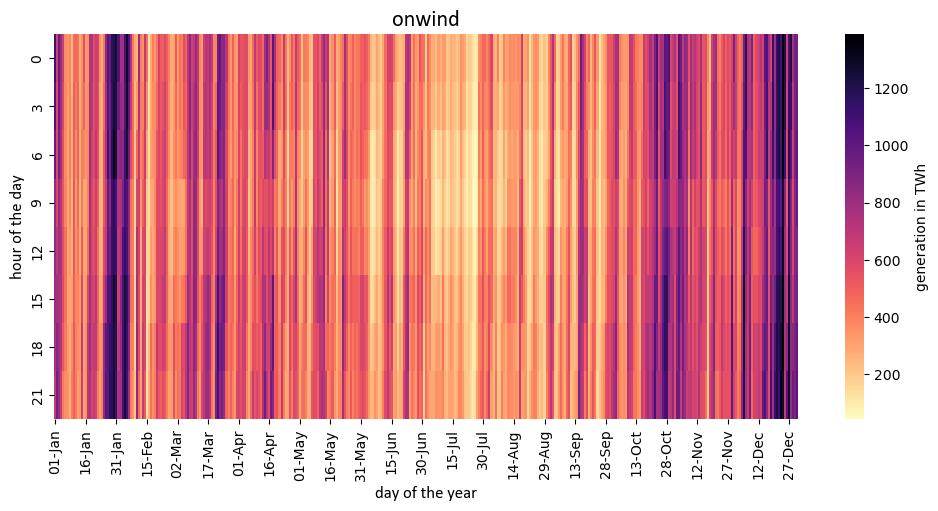

In [58]:
# generation through time as heatmap

carrier = "onwind"

# get generation in TWh
df = pd.DataFrame(n.generators_t.p.loc[:, n.generators.carrier == carrier].sum(axis=1)) / 1000

hours = df.index.hour.unique()
df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

for hour in hours:
    df_start[str(hour)] = df[df.index.hour==hour].values

plt.figure(figsize=(12, 5))
ax = sns.heatmap(df_start.transpose(),
                 cmap=plt.get_cmap("magma_r"),
                 linewidth=0.001,
                 xticklabels=15,
                 cbar_kws={'label': 'generation in TWh'})

plt.title(f"{carrier}", fontsize=16, **font1)
plt.ylabel("hour of the day", fontsize=12, **font1)
plt.xlabel("day of the year", fontsize=12, **font1)

# Rewrite the y labels
x_labels = ax.get_xticks()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

plt.show()

In [59]:
#TODO: you could calc capacity factors for every time step and also plot them as heatmap

### Full load hours

In [60]:
# how are the full load hours aggregated:
# sum over the flh in every region adn time step (sumover time) -> you recieve flh for every region over the time

th = 0.9
n = n_no
df = df_no_ons

# get full_load hours (generators)
for carrier in n.generators.carrier.unique():
    gen = n.generators_t.p[n.generators[n.generators.carrier == carrier].index]
    # max_output = n.generators.p_nom_opt[n.generators.carrier == carrier]
    max_output = gen.max()

    # ts with max_output
    max_output_ts = gen.copy()
    for snap in n.storage_units_t.p.index:
        max_output_ts.loc[snap] = max_output[max_output_ts.columns]

    # calc full load hours
    flh = (gen >= th * max_output_ts).sum()
    flh.index = flh.index.map(n.generators.bus).map(n.buses.location)
    df[f"{carrier}_flh"] = flh

# links
for carrier in n.links.carrier.unique():
    gen = abs(n.links_t.p1.loc[:, n.links.carrier == carrier])
    # use p_nom_opt as indicator for full load hour
    # max_output = n.links.p_nom_opt[n.links.carrier == carrier]
    # use maximum of generation output as indicator for full load hour
    max_output = gen.max()

    # ts with p_nom_opt
    max_output_ts = gen.copy()
    for snap in n.storage_units_t.p.index:
        max_output_ts.loc[snap] = max_output[max_output_ts.columns]

    # calc full load hours
    flh = (gen >= th * max_output_ts).sum()
    flh.index = flh.index.map(n.links.bus1).map(n.buses.location)
    # group duplicate index entries
    flh = flh.groupby(by=["Link"], axis="index").sum()
    df[f"{carrier}_flh"] = flh

# storage units
for carrier in n.storage_units.carrier.unique():
    gen = n.storage_units_t.p_dispatch.loc[:, n.storage_units.carrier == carrier]
    max_output = gen.max()

    max_output_ts = gen.copy()
    for snap in n.storage_units_t.p.index:
        max_output_ts.loc[snap] = max_output[max_output_ts.columns]

    # calc full load hours
    flh = (gen >= th * max_output_ts).sum()
    flh.index = flh.index.map(n.storage_units.bus).map(n.buses.location)
    df[f"{carrier}_flh"] = flh

df.head(3)

KeyboardInterrupt: 

In [ ]:
# full load hours
boxprops=dict(facecolor="white", color="white")
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}

i_no_gen_rev = [carrier_renaming_reverse.get(n, n) for n in i_no_gen]
# multiply with 3 to account for the 3h resolution
df = df_no_ons[[f"{i}_flh" for i in i_no_gen_rev]]*3
df = df.values

# Filter data using np.isnan
mask = ~np.isnan(df)
filtered_data = [d[m] for d, m in zip(df.T, mask.T)]

fig, ax = plt.subplots(figsize=(12, 4))
bp = plt.boxplot(x=filtered_data, labels =i_no_gen, patch_artist=True, showmeans=True, boxprops=boxprops, meanprops=meanprops, medianprops=medianprops)

for box, col in zip(bp['boxes'],[carrier_colors[c] for c in i_no_gen]):
    # change outline color
    box.set(color=col, linewidth=2)

plt.title("Title")
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)
plt.xticks(rotation=90)
plt.title("Full load hours", fontsize=16, pad=15,  **font1)
plt.show()

### Utilitization rate

In [ ]:
# what you actually want to measure is on how much of possible generation is utilized
# utilitazation rate???
# Problem if you calc the rate for every time step and location independently and then take the mean, all urs have the same weight. That makes no sense, as at times with almost no generation there is numerical issues with the rate
# better calc ur for every region as the ratio of the sum over all gen and the sum over all possible gen (make sure only valid regions make it to the plot, e.g. minimun generation of o,2 quantile)

th = 0.01 # MWh
method = 1

# generators
max_out_gen = n.generators_t.p_max_pu * n.generators.p_nom_opt[n.generators_t.p_max_pu.columns]
real_out_gen = n.generators_t.p[n.generators_t.p_max_pu.columns]
out_ratio_gen = (real_out_gen / max_out_gen) [real_out_gen > th]
out_ratio_gen_sum = real_out_gen.sum() / max_out_gen.sum()

# links
# gen
n_links_p1 = n.links_t.p1 *-1
# some links have a static p_max_pu value and some have an alternating (series)
index_series_li = n.links_t.p_max_pu.columns
index_static_li = n.links.index.difference(n.links_t.p_max_pu.columns)

# calculate the possible output for the link for every time step
if method == 1:
    # use p_max_pu * p_nom_op
    max_output_links_static = n.links.loc[index_static_li].p_max_pu * n.links.loc[index_static_li].p_nom_opt
elif method == 2:
    # alternatively use the maximum of the real output and set it as the maximum capacity
    max_output_links_static= n_links_p1[index_static_li].max()

# make ts of max_output_links_static
max_output_links_ts_static = n.links_t.p0[index_static_li].copy()
for snap in n.links_t.p0.index:
    max_output_links_ts_static.loc[snap] = max_output_links_static[index_static_li]

# calc time series of time dependent p_max_pu links
max_output_links_ts_series = n.links_t.p_max_pu * n.links.p_nom_opt[index_series_li]

# merge static and series values and reorder columns
max_output_links_ts = pd.concat([max_output_links_ts_static, max_output_links_ts_series], axis=1)[n.links_t.p0.columns]

# compare to real output
out_ratio_links = (n_links_p1 / max_output_links_ts) [n_links_p1 > th]
# calc out ratio weighted by generation (sum of all gen / sum of all cap / max_output)
out_ratio_links_sum = n_links_p1.sum() / max_output_links_ts.sum()

# storage units
max_output = n.storage_units.p_max_pu * n.storage_units.p_nom_opt
max_output_ts_su = n.storage_units_t.p.copy()
for snap in n.storage_units_t.p.index:
    max_output_ts_su.loc[snap] = max_output[n.storage_units_t.p.columns]
# compare to real output
out_ratio_su = (n.storage_units_t.p_dispatch / max_output_ts_su) [n.storage_units_t.p_dispatch > th]
out_ratio_su_sum = n.storage_units_t.p_dispatch.sum() / max_output_ts_su.sum()

In [ ]:
n.storage_units_t.p_dispatch.sum()

In [ ]:
max_output_ts_su.sum()

In [ ]:
th_p = 0.01 # share of mean generation
n = n_no
df = df_no_ons

# how much of the whole possible energy that can be generated is utilized (sum over all time steps and location than take ratio)
overall_ur = pd.DataFrame(index=range(1))

# gens
for carrier in n.generators.carrier.unique():
    if carrier in ['gas', 'oil']:
        continue
    # calc ur as mean of all urs per time and space
    index = n.generators[n.generators.carrier == carrier].index
    ur = out_ratio_gen[index].mean()
    ur.index = ur.index.map(n.generators.bus).map(n.buses.location)
    df[f"{carrier}_ur_mean"] = ur

    # calc ur as ratio of sum of all gen and sum of all output
    ur_s = out_ratio_gen_sum[index][real_out_gen[index].sum() > real_out_gen[index].sum().mean() * th_p]
    ur_s.index = ur_s.index.map(n.generators.bus).map(n.buses.location)
    df[f"{carrier}_ur"] = ur_s

    # overall ur
    overall_ur[f"{carrier}"] = real_out_gen[index].sum().sum() / max_out_gen[index].sum().sum()

# links
for carrier in n.links.carrier.unique():
    # calc
    index = n.links[n.links.carrier == carrier].index
    ur = out_ratio_links[index].mean()
    ur.index = ur.index.map(n.links.bus1).map(n.buses.location)
    # group duplicate index entries
    ur = ur.groupby(by=["Link"], axis="index").mean()
    df[f"{carrier}_ur_mean"] = ur

    # calc ur as ratio of sum of all gen and sum of all output
    ur_s = out_ratio_links_sum[index][n_links_p1[index].sum() > n_links_p1[index].sum().mean() * th_p]
    ur_s.index = ur_s.index.map(n.links.bus1).map(n.buses.location)
    # group duplicate index entries
    ur_s = ur_s.groupby(by=["Link"], axis="index").mean()
    df[f"{carrier}_ur"] = ur_s

    # overall ur
    overall_ur[f"{carrier}"] = n_links_p1[index].sum().sum() / max_output_links_ts[index].sum().sum()

# storage units
for carrier in n.storage_units.carrier.unique():
    # calc
    index = n.storage_units[n.storage_units.carrier == carrier].index
    ur = out_ratio_su[index].mean()
    ur.index = ur.index.map(n.storage_units.bus).map(n.buses.location)
    df[f"{carrier}_ur_mean"] = ur

    #
    ur_s = out_ratio_su_sum[index][n.storage_units_t.p_dispatch[index].sum() > n.storage_units_t.p_dispatch[index].sum().mean() * th_p]
    ur_s.index = ur_s.index.map(n.storage_units.bus).map(n.buses.location)
    df[f"{carrier}_ur"] = ur_s

    # overall ur
    overall_ur[f"{carrier}"] = n.storage_units_t.p_dispatch[index].sum().sum() / max_output_ts_su[index].sum().sum()

df.head(3)

In [ ]:
out_ratio_su_sum

In [ ]:
carrier = "hydro"
index = n.storage_units[n.storage_units.carrier == carrier].index
ur_s = out_ratio_su_sum[index][n.storage_units_t.p_dispatch[index].sum() > n.storage_units_t.p_dispatch[index].sum().mean() * th_p]
ur_s.index = ur_s.index.map(n.storage_units.bus).map(n.buses.location)
ur_s

In [ ]:
# utilitization rate

boxprops=dict(facecolor="white", color="white")
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}

i_no_gen_rev = [carrier_renaming_reverse.get(n, n) for n in i_no_gen]
df = df_no_ons[[f"{i}_ur" for i in i_no_gen_rev]]
df = df.values

# Filter data using np.isnan
mask = ~np.isnan(df)
filtered_data = [d[m] for d, m in zip(df.T, mask.T)]

fig, ax = plt.subplots(figsize=(12, 6))
bp = plt.boxplot(filtered_data, labels =i_no_gen, patch_artist=True, showmeans=False, boxprops=boxprops, meanprops=meanprops, medianprops=medianprops)

for box, col in zip(bp['boxes'],[carrier_colors[c] for c in i_no_gen]):
    # change outline color
    box.set(color=col, linewidth=2)

plt.title("Title")
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)
plt.xticks(rotation=90)
plt.title("Utilitization rate of electricity generating technologies across the regions (STST)", fontsize=16, pad=20,  **font1)
ax.plot(np.arange(1,17), overall_ur[i_no_gen_rev].transpose(),"x", marker='*', color="red", markersize= 10, markerfacecolor="white")

for i, sample_size in enumerate(df_no_ons[[f"{i}_ur" for i in i_no_gen_rev]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/16,1), textcoords='axes fraction', color="blue")

fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/ur_el_con_STST.png")

# red stars symbolize overall utilization rate
# "home battery discharger" has maximum generation over all snaps and locations of 0.29
# "urban central gas CHP CC" has maximum generation over all snaps and locations of 0.20

In [ ]:
overall_ur[i_no_gen_rev]

In [ ]:
df_no_ons[[f"{i}_ur" for i in i_no_gen_rev]]["hydro_ur"]

In [ ]:
# 1: what does it mean if the star is outside the box / whiskers: star below box (hydro) means that most of the regions are having higher ur than the overall utilitization. The regions with most generation have a lower ur than the average

# 2: what is the difference between the capacity facotr and the utilitization rate for technologies with a constant capacity e.g. gas CHP? Shouldnt this be the same? Because it is not.

In [ ]:
# Further investigation

# storage unit
carrier = "hydro"
df_no_ons[f"{carrier}_ur"]
gen = n.storage_units_t.p_dispatch[n.storage_units[n.storage_units.carrier == carrier].index].sum()
gen.index = gen.index.map(n.storage_units.bus).map(n.buses.location)
gen = gen[df_no_ons[f"{carrier}_ur"].dropna().index]

fig, ax1 = plt.subplots(figsize=(14,6))

ax2 = ax1.twinx()
ax1.plot(df_no_ons[f"{carrier}_ur"].dropna(), 'g-', label=f"{carrier}_ur")
ax2.plot(gen.dropna(), 'b-', label="generation")
ax1.legend(loc="upper center")
ax2.legend()

plt.show()

In [ ]:
# link
carrier = "battery charger"
df_no_ons[f"{carrier}_ur"]
gen = n_links_p1[n.links[n.links.carrier == carrier].index].sum()
gen.index = gen.index.map(n.links.bus1).map(n.buses.location)
gen = gen[df_no_ons[f"{carrier}_ur"].dropna().index]

fig, ax1 = plt.subplots(figsize=(14,6))

ax2 = ax1.twinx()
ax1.plot(df_no_ons[f"{carrier}_ur"].dropna(), 'g-', label=f"{carrier}_ur")
ax2.plot(gen.dropna(), 'b-', label="generation")
ax1.legend(loc="upper center")
ax2.legend()

plt.show()

In [ ]:
gen.sort_values(ascending=False)

In [ ]:
df_no_ons[f"{carrier}_ur"].loc[gen.sort_values(ascending=False).index]

In [ ]:
# Norway indices
no_i = gen.index[gen.index.str.contains('NO')]

In [ ]:
df_no_ons[f"{carrier}_ur"][no_i]#.mean()
# why are all the value for norway the same??

In [ ]:
gen[no_i].sum() / gen.sum()

### Generation profiles

In [ ]:
# generators, links, and storage units
carriers = ["battery discharger", "hydro"]
n = n_no

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(18, 6))

for i, ax in enumerate(axs):

    if carriers[i] in n.generators.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.generators_t.p.loc[:, n.generators.carrier == carriers[i]].sum(axis=1)) / 1000

    elif carriers[i] in n.links.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.links_t.p0.loc[:, n.links.carrier == carriers[i]].sum(axis=1)) / 1000

    elif carriers[i] in n.storage_units.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.storage_units_t.p_dispatch.loc[:, n.storage_units.carrier == carriers[i]].sum(axis=1)) / 1000

    hours = df.index.hour.unique()[::-1]
    df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

    for hour in hours:
        df_start[str(hour)] = df[df.index.hour==hour].values

    sns.heatmap(df_start.transpose(),
                ax=ax,
                cmap=plt.get_cmap("magma_r"),
                linewidth=0.001,
                xticklabels=15,
                cbar_kws={'label': 'Generation in TWh', 'pad': 0.09}
                )


    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)
    ax.set_ylabel("hour of the day", fontsize=12, **font1)
    ax.set_xlabel("day of the year", fontsize=12, **font1)
    #plt.colorbar(im,fraction=0.046, pad=0.04)

    # Rewrite the y labels
    ax_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

    # Plot generation profile on second y-axis
    # resample and transform axis of date to index (heatmap works not with dates)
    df2 = df.resample("5D").sum()
    df2 = df2[df2.index.year == 2013]
    df2.index = df2.index.dayofyear - 0.5

    ax2 = ax.twinx()
    ax2.plot(df2, color="white", lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.legend( loc='lower right', labels=['Daily generation (right axis)'])
    ax2.set_ylabel("Sum of daily generation in TWh", fontsize=12, **font1)
    ax2.grid(False)

fig.tight_layout(pad=3)
plt.show()

In [ ]:
# thesis plot

# generators, links, and storage units
carriers = ["onwind", "solar", "offwind-dc", "ror"]
n = n_no

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(18, 10))

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in n.generators.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.generators_t.p.loc[:, n.generators.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    elif carriers[i] in n.links.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.links_t.p0.loc[:, n.links.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    elif carriers[i] in n.storage_units.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.storage_units_t.p_dispatch.loc[:, n.storage_units.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    else:
        print(f"{carriers[i]} does not exist!")


    hours = df.index.hour.unique()[::-1]
    df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

    for hour in hours:
        df_start[str(hour)] = df[df.index.hour==hour].values

    sns.heatmap(df_start.transpose(),
                ax=ax,
                cmap=plt.get_cmap("magma_r"),
                linewidth=0.001,
                xticklabels=15,
                cbar_kws={'label': 'Generation in TWh', 'pad': 0.1})

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)
    ax.set_ylabel("hour of the day", fontsize=12, **font1)
    ax.set_xlabel("day of the year", fontsize=12, **font1)

    # Rewrite the y labels
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

    # Plot generation profile on second y-axis
    # resample and transform axis of date to index (heatmap works not with dates)
    df2 = df.resample("5D").sum() / 1000
    df2 = df2[df2.index.year == 2013]
    df2.index = df2.index.dayofyear - 0.5

    ax2 = ax.twinx()
    ax2.plot(df2, color="white", lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.legend( loc='lower right', labels=['Generation (right axis)'])
    ax2.set_ylabel("Generation in GWh (5-day sum)", fontsize=12, **font1)
    ax2.grid(False)

fig.tight_layout(pad=3)
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_gen_profile_vre_STST.png")

In [ ]:
# thesis plot

# generators, links, and storage units
carriers = ["battery discharger", "hydro", "V2G", "PHS"]
n = n_no

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(18, 10))

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in n.generators.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.generators_t.p.loc[:, n.generators.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    elif carriers[i] in n.links.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.links_t.p0.loc[:, n.links.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    elif carriers[i] in n.storage_units.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.storage_units_t.p_dispatch.loc[:, n.storage_units.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    else:
        print(f"{carriers[i]} does not exist!")


    hours = df.index.hour.unique()[::-1]
    df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

    for hour in hours:
        df_start[str(hour)] = df[df.index.hour==hour].values

    sns.heatmap(df_start.transpose(),
                ax=ax,
                cmap=plt.get_cmap("magma_r"),
                linewidth=0.001,
                xticklabels=15,
                cbar_kws={'label': 'Generation in TWh', 'pad': 0.1})

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)
    ax.set_ylabel("hour of the day", fontsize=12, **font1)
    ax.set_xlabel("day of the year", fontsize=12, **font1)

    # Rewrite the y labels
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

    # Plot generation profile on second y-axis
    # resample and transform axis of date to index (heatmap works not with dates)
    df2 = df.resample("20D").sum() / 1000
    df2 = df2[df2.index.year == 2013]
    df2.index = df2.index.dayofyear - 0.5

    ax2 = ax.twinx()
    ax2.plot(df2, color="white", lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.legend( loc='lower right', labels=['Generation (right axis)'])
    ax2.set_ylabel("Generation in GWh (5-day sum)", fontsize=12, **font1)
    ax2.grid(False)

fig.tight_layout(pad=3)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_gen_profile_store_STST.png")

In [ ]:
# thesis plot

# generators, links, and storage units
carriers = ["urban central gas CHP", "urban central solid biomass CHP CC" ]
n = n_no

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(18, 5))

for i, ax in enumerate(axs):

    if carriers[i] in n.generators.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.generators_t.p.loc[:, n.generators.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    elif carriers[i] in n.links.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.links_t.p0.loc[:, n.links.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    elif carriers[i] in n.storage_units.carrier.unique().tolist():
        # get generation in TWh
        df = pd.DataFrame(n.storage_units_t.p_dispatch.loc[:, n.storage_units.carrier == carriers[i]].sum(axis=1)) / 1000 * 3

    else:
        print(f"{carriers[i]} does not exist!")


    hours = df.index.hour.unique()[::-1]
    df_start = pd.DataFrame(index=pd.Index(df.index.date).unique())

    for hour in hours:
        df_start[str(hour)] = df[df.index.hour==hour].values

    sns.heatmap(df_start.transpose(),
                ax=ax,
                cmap=plt.get_cmap("magma_r"),
                linewidth=0.001,
                xticklabels=15,
                cbar_kws={'label': 'Generation in TWh', 'pad': 0.1})

    ax.set_title(carriers[i].replace("urban central solid ", "").replace("urban central ", ""), fontsize=16, **font1)
    ax.set_ylabel("hour of the day", fontsize=12, **font1)
    ax.set_xlabel("day of the year", fontsize=12, **font1)

    # Rewrite the y labels
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%b'))

    # Plot generation profile on second y-axis
    # resample and transform axis of date to index (heatmap works not with dates)
    df2 = df.resample("5D").sum() / 1000
    df2 = df2[df2.index.year == 2013]
    df2.index = df2.index.dayofyear - 0.5

    ax2 = ax.twinx()
    ax2.plot(df2, color="white", lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
    ax2.legend( loc='lower right', labels=['Generation (right axis)'])
    ax2.set_ylabel("Generation in GWh (5-day sum)", fontsize=12, **font1)
    ax2.grid(False)


fig.tight_layout(pad=3)
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/el_gen_profile_peak_STST.png")

In [ ]:
df_start.transpose()

### Storage

In [ ]:
### hydro generation
# plt.plot(n.storage_units_t.p_dispatch.loc[:, n.storage_units.carrier == "hydro"].sum(axis=1))

In [ ]:
### hydro water availability
plt.plot(n.storage_units_t.inflow.loc[:, n.storage_units.carrier == "hydro"].sum(axis=1).cumsum())

In [ ]:
### hydro water availability
plt.plot(n.storage_units_t.spill.loc[:, n.storage_units.carrier == "hydro"].sum(axis=1))

In [ ]:
# State of charge [per unit of max] (all stores and storage units)
# Ratio of total generation of max state of charge

gen_charge_ratio= []
max_charge= []

st_carriers = ["battery", "Li ion", "hydro", "PHS"]
carriers = ["battery discharger", "V2G", "hydro", "PHS"]
n = n_no
period= "2013"

stor_res = pd.DataFrame(index = st_carriers, columns =["max_charge", "gen_charge_ratio", "max_stor_cap", "gen_charge_cap_ratio", "gen_sum" ])

fig = plt.figure(figsize=(9,6))

for i, c in enumerate(st_carriers):
    if c in n.storage_units.carrier.unique().tolist():
        # state of charge (sum over locations: 2920 values)
        charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]
        gen_sum = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carriers[i]].sum().sum()
        gen = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carriers[i]].sum(axis=1)
        index = n.storage_units[n.storage_units.carrier == c].index
        max_stor_cap = (n.storage_units.max_hours * n.storage_units.p_nom_opt)[index].sum()
        stor_res.loc[c, "max_charge"] = charge.max()
        stor_res.loc[c, "gen_charge_ratio"] = gen_sum/charge.max()
        stor_res.loc[c, "max_stor_cap"] = max_stor_cap
        stor_res.loc[c, "gen_charge_cap_ratio"] = gen_sum/max_stor_cap
        stor_res.loc[c, "gen_sum"] = gen_sum

    elif c in n.stores.carrier.unique().tolist():
        # state of charge (sum over locations: 2920 values)
        charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]
        gen_sum = -n.links_t.p1.loc[period, n.links.carrier == carriers[i]].sum().sum()
        max_stor_cap = n.stores.e_nom_opt[n.stores[n.stores.carrier == c].index].sum()
        stor_res.loc[c, "max_charge"] = charge.max()
        stor_res.loc[c, "gen_charge_ratio"] = gen_sum/charge.max()
        stor_res.loc[c, "max_stor_cap"] = max_stor_cap
        stor_res.loc[c, "gen_charge_cap_ratio"] = gen_sum/max_stor_cap
        stor_res.loc[c, "gen_sum"] = gen_sum

    plt.plot(charge/max_stor_cap, label=c, color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black')

plt.ylabel("State of charge [per unit of max storage capacity]")
plt.legend()
plt.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/charge_state_store_STST.png")

In [ ]:
# Ratio of total generation of max state of charge
stor_res["max_charge_max_stor_cap_ratio"] =  stor_res["max_charge"] / stor_res["max_stor_cap"]
stor_res

In [ ]:
# TWh
stor_res["max_stor_cap"] / 1e6

In [ ]:
# how do I get the maximum storage capacity?

# stores:
c = "battery"
index = n.stores[n.stores.carrier == c].index
n.stores.e_nom_opt[index]

# storage units:
c = "hydro"
index = n.storage_units[n.storage_units.carrier == c].index
(n.storage_units.max_hours * n.storage_units.p_nom_opt)[index].sum()

In [ ]:
# State of charge [per unit of max] (all stores and storage units)
# Ratio of total generation of max state of charge
import matplotlib.ticker as ticker

gen_charge_ratio= []
max_charge= []

carriers = ["battery", "battery discharger", "battery charger"]
n = n_no
start_date = "2013-06-1 00:00:00"
end_date = "2013-06-09 00:00:00"
period = n_no.generators_t.p.index[(n_no.generators_t.p.index >= start_date) & (n_no.generators_t.p.index <= end_date)]

fig = plt.figure(figsize=(8,4))

for i, c in enumerate(carriers):
    if c in n.storage_units.carrier.unique().tolist():
        # state of charge (sum over locations: 2920 values)
        charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]
        gen_sum = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carriers[i]].sum().sum()
        gen = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carriers[i]].sum(axis=1)
        index = n.storage_units[n.storage_units.carrier == c].index
        max_stor_cap = (n.storage_units.max_hours * n.storage_units.p_nom_opt)[index].sum()
        stor_res.loc[c, "max_charge"] = charge.max()
        stor_res.loc[c, "gen_charge_ratio"] = gen_sum/charge.max()
        stor_res.loc[c, "max_stor_cap"] = max_stor_cap

        plt.plot(charge/max_stor_cap, label=c, color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black',linewidth=3)
        plt.plot(gen/gen.max(), label=f"{c}", color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black', ls="--", linewidth=3)

    elif c in n.links.carrier.unique().tolist():
        gen = -n.links_t.p1.loc[period, n.links.carrier == c].sum(axis=1)

        plt.plot(gen/gen.max(), label=f"{c}", color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black', ls=":", linewidth=3)

    elif c in n.stores.carrier.unique().tolist():
        # state of charge (sum over locations: 2920 values)
        charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]
        gen_sum = -n.links_t.p1.loc[period, n.links.carrier == carriers[i]].sum().sum()
        max_stor_cap = n.stores.e_nom_opt[n.stores[n.stores.carrier == c].index].sum()
        stor_res.loc[c, "max_charge"] = charge.max()
        stor_res.loc[c, "gen_charge_ratio"] = gen_sum/charge.max()
        stor_res.loc[c, "max_stor_cap"] = max_stor_cap

        plt.plot(charge/max_stor_cap, label=c, color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black',linewidth=3)

plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H')) # %d-%m
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.125))
plt.ylabel("State of charge and generation [per unit of max]")
plt.xlabel("Hour of the day")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
# State of charge [per unit of max] (all stores and storage units)
# Ratio of total generation of max state of charge
import matplotlib.ticker as ticker

temp_colors = {
    'PHS': 'darkorange',
    'hydro': 'navy'
}

carrier_lists =[["battery", "battery discharger", "battery charger"],["hydro", "PHS"]]

n = n_no
start_date = "2013-06-6 00:00:00"
end_date = "2013-06-10 00:00:00"
period = n_no.generators_t.p.index[(n_no.generators_t.p.index >= start_date) & (n_no.generators_t.p.index <= end_date)]

fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(10,6))

for j, ax in enumerate(axs):
    carriers = carrier_lists[j]

    for i, c in enumerate(carriers):
        if c in n.storage_units.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]
            gen_sum = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carriers[i]].sum().sum()
            gen = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carriers[i]].sum(axis=1)
            index = n.storage_units[n.storage_units.carrier == c].index
            max_stor_cap = (n.storage_units.max_hours * n.storage_units.p_nom_opt)[index].sum()
            stor_res.loc[c, "max_charge"] = charge.max()
            stor_res.loc[c, "gen_charge_ratio"] = gen_sum/charge.max()
            stor_res.loc[c, "max_stor_cap"] = max_stor_cap

            ax.plot(charge/max_stor_cap, label=c, color=temp_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black',linewidth=2)
            ax.plot(gen/gen.max(), label=f"{c} (generation)", color=temp_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black', ls=":", linewidth=3)

        elif c in n.links.carrier.unique().tolist():
            gen = -n.links_t.p1.loc[period, n.links.carrier == c].sum(axis=1)

            ax.plot(gen/gen.max(), label=f"{c}", color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black', ls=":", linewidth=3)

        elif c in n.stores.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]
            gen_sum = -n.links_t.p1.loc[period, n.links.carrier == carriers[i]].sum().sum()
            max_stor_cap = n.stores.e_nom_opt[n.stores[n.stores.carrier == c].index].sum()
            stor_res.loc[c, "max_charge"] = charge.max()
            stor_res.loc[c, "gen_charge_ratio"] = gen_sum/charge.max()
            stor_res.loc[c, "max_stor_cap"] = max_stor_cap

            ax.plot(charge/max_stor_cap, label=c, color=carrier_colors[c], marker=markers[i], markevery=[0], mfc='white', mec='black',linewidth=3)

    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H')) # %d-%m
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.125))
    ax.set_ylabel("Charge / generation [per unit of max]")
    ax.set_xlabel("Hour of the day")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/charge_state_store_daily_STST.png")

In [ ]:
stor_res

In [ ]:
charge = n.stores_t.e.loc[:, n.stores.carrier == "battery"].sum(axis=1)
gen = n.links_t.p1.loc[:, n.links.carrier == "battery discharger"].sum().sum()

In [ ]:
# State of charge [per unit of max]
carrier = "H2"

# state of charge (sum over locations: 2920 values)
charge = n.stores_t.e.loc[:, n.stores.carrier == carrier].sum(axis=1)

In [ ]:
plt.plot(charge/charge.max())

#### How long is one unit on average stored?
- LIFO
- Distribution of storage time over the year
- watch out as the smallest can be ony minimum 3h steps

In [ ]:
temp_colors = {
    'PHS': 'purple',
    'hydro': 'navy',
    'battery': 'hotpink',
    'gas': 'orange',
    'H2': 'turquoise',
    'Li ion': 'greenyellow',
    'home battery': 'violet',
    'oil': 'k',
    'solid biomass': 'sandybrown',
    'biogas': 'palegoldenrod',
}

In [ ]:
# singel case
c = "battery"
charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)
result = time_stored_LIFO(charge)

amounts = pd.DataFrame(result[[f"amount{i}" for i in range(1,int(((len(result.columns) - 3) / 2)))]].values.flatten())
timedeltas = pd.DataFrame(result[[f"timedelta{i}" for i in range(1,int(((len(result.columns) - 3) / 2)))]].values.flatten())

all_df = pd.concat([ amounts, timedeltas], axis=1).dropna()
all_df.columns = ["amounts", "timedeltas"]
all_df["hours"] = (all_df["timedeltas"] /  timedelta(hours=1)).astype(int)

In [ ]:
# barplot duration of storage per amountof stored energy

carriers = ["battery", "PHS", "hydro", "gas", "H2", "Li ion", "home battery", "oil"]

n = n_no
start_date = "2013-06-6 00:00:00"
end_date = "2013-06-10 00:00:00"
period = n_no.generators_t.p.index[(n_no.generators_t.p.index >= start_date) & (n_no.generators_t.p.index <= end_date)]
period="2013"

bins = [0, 6, 12, 18, 24, 2*24, 3*24, 7*24, 14*24, 30*24,60*24,120*24, np.inf]
bins_labels = ["[0h,6h]", "(6h,12h]", "(12h,18h]", "(18h,24h]", "(24h,2d]","(2d,3d]","(3d,7d]", "(7d,14d]", "(14d,30d]","(30d,60d]","(60d,120d]", " > 120d" ]

res_grouped = pd.DataFrame(index= bins_labels)

for c in carriers:
        if c in n.storage_units.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]

        elif c in n.stores.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]

        else:
            print(f"{c} does not exist!")

        result = time_stored_LIFO(charge)

        # get amounts and timedeltas
        i = int(((len(result.columns) - 3) / 2))
        amounts = pd.DataFrame(result[[f"amount{i}" for i in range(1,i+1)]].values.flatten(order='C'))
        timedeltas = pd.DataFrame(result[[f"timedelta{i}" for i in range(1,i+1)]].values.flatten(order='C'))
        all_df = pd.concat([ amounts, timedeltas], axis=1).dropna()
        all_df.columns = ["amounts", "timedeltas"]
        all_df["hours"] = (all_df["timedeltas"] /  timedelta(hours=1)).astype(int)

        # groupby hours and normalise
        all_df_grouped = all_df[["amounts", "hours"]].groupby(by="hours").sum() / all_df["amounts"].sum()

        #binning
        all_df_grouped["bins"] = pd.cut(x=all_df_grouped.index, bins=bins, labels=bins_labels, right=True)

        # save to result
        res_grouped[c] = all_df_grouped[["amounts", "bins"]].groupby(by="bins").sum()

In [ ]:
res_grouped

In [ ]:
# carriers = ["battery", "PHS", "hydro", "gas", "H2", "Li ion", "home battery", "oil"]

fig = res_grouped.reset_index().plot(x="index", y=carriers, kind="bar",
                               rot=0,
                               figsize=(18,6),
                               color=[temp_colors[c] for c in carriers],
                               xlabel="",
                               ylabel="Amount of stored energy (%)",
                               width=0.85
                               ).get_figure()
plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/storage_time_bars_STST.png")

In [ ]:
res_grouped.describe()

In [ ]:
# Distribution of storage time over the year

In [ ]:
carriers = ["battery", "PHS", "hydro", "gas", "H2", "Li ion", "biogas", "solid biomass", "oil", "home battery" ]

n = n_no
start_date = "2013-06-6 00:00:00"
end_date = "2013-06-10 00:00:00"
period = n_no.generators_t.p.index[(n_no.generators_t.p.index >= start_date) & (n_no.generators_t.p.index <= end_date)]
period="2013"

res = pd.DataFrame(index= np.arange(1,13))

for c in carriers:
        if c in n.storage_units.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]

        elif c in n.stores.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]

        else:
            print(f"{c} does not exist!")

        result = time_stored_LIFO(charge)

        # get amounts and timedeltas
        i = int(((len(result.columns) - 3) / 2))
        amounts = pd.DataFrame(result[[f"amount{i}" for i in range(1,i+1)]].values.flatten(order='C'))
        timedeltas = pd.DataFrame(result[[f"timedelta{i}" for i in range(1,i+1)]].values.flatten(order='C'))

        #
        all_df = pd.concat([ amounts, timedeltas], axis=1)
        all_df.columns = ["amounts", "timedeltas"]
        all_df.index = result.index.repeat(i)
        all_df.dropna(inplace=True)
        all_df["hours"] = (all_df["timedeltas"] /  timedelta(hours=1)).astype(int)
        all_df["months"] = all_df.index.month
        all_df["amounts_hours"] = all_df.amounts * all_df.hours

        # calc generation weighted average
        res[c] = all_df.groupby(by="months")["amounts_hours"].sum() / all_df.groupby(by="months")["amounts"].sum()


In [ ]:
res

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=(12, 8))

# plot 1 (hours)
c_plot = ["battery", "Li ion", "home battery"]
res[c_plot].reset_index().plot(x="index", y=c_plot, kind="bar",
                               rot=0,
                               color=[temp_colors[c] for c in c_plot],
                               xlabel="Month",
                               ylabel="Hours stored",
                               ax=ax1
                               )

# plot 2 (days)
c_plot = ["PHS", "hydro", "gas", "H2", "oil"] # "biogas",, "solid biomass"

# days
df = res[c_plot] / 24
df.reset_index().plot(x="index",
                      y=c_plot, kind="bar",
                      rot=0,
                      color=[temp_colors[c] for c in c_plot],
                      xlabel="Month",
                      ylabel="Days stored",
                      ax=ax2,
                      width=0.85
                      )

plt.show()

fig.savefig(f"{PLOT_DIR}01_general/4.2_systems_technologies/storage_time_months_STST.png")

In [ ]:
res[9:12].mean()

In [ ]:
c = "H2"

start_date = "2013-02-1 00:00:00"
end_date = "2013-03-01 00:00:00"
period = n_no.generators_t.p.index[(n_no.generators_t.p.index >= start_date) & (n_no.generators_t.p.index <= end_date)]
period = "2013"

if c in n.storage_units.carrier.unique().tolist():
    # state of charge (sum over locations: 2920 values)
    charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]

elif c in n.stores.carrier.unique().tolist():
    # state of charge (sum over locations: 2920 values)
    charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, figsize=(12, 10))

ax1.plot(charge - charge.mean(), color="blue")
ax1.set_title(f"State of charge ({c})")
ax2.plot(charge.diff()[charge.diff() > 0], color="red", lw=2) # .resample("3h").mean()
ax2.set_title(f"Charging ({c})")
ax3.plot(charge.diff()[charge.diff() < 0].resample("3h").mean(), color="gold", lw=2)
ax3.set_title(f"Discharging ({c})")
plt.show()

In [ ]:
plt.plot(charge.diff())

In [ ]:
c_plot = ["biogas", "solid biomass"]

# days
df = res[c_plot] / 24
df.reset_index().plot(x="index",
                      y=c_plot, kind="bar",
                      rot=0,
                      figsize=(12,4),
                      color=[temp_colors[c] for c in c_plot],
                      xlabel="Month",
                      ylabel="Days stored",
                      )

plt.show()

In [ ]:
# furier transform to detect seasonality of state of charge

carriers = ["battery", "PHS", "hydro", "gas", "H2", "Li ion", "biogas", "solid biomass", "oil", "home battery" ]

n = n_no
period="2013"

res_charge_state = pd.DataFrame(index= charge.index)

for c in carriers:
        if c in n.storage_units.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.storage_units_t.state_of_charge.loc[:, n.storage_units.carrier == c].sum(axis=1)[period]

        elif c in n.stores.carrier.unique().tolist():
            # state of charge (sum over locations: 2920 values)
            charge = n.stores_t.e.loc[:, n.stores.carrier == c].sum(axis=1)[period]

        else:
            print(f"{c} does not exist!")

        res_charge_state[c] = charge


In [ ]:
for c, d in res_charge_state.iteritems():
    fig, ax = plt.subplots()
    fft = abs(pd.Series(np.fft.rfft(d - d.mean()), index=np.fft.rfftfreq(len(d), d=1./2920))**2)
    fft.plot(xlim=[0,1000], ylabel=f"??? Density ({c})", xlabel="Frequency (1/year)")
    print(c)
    print(pd.DataFrame(fft).sort_values(by=0, ascending=False).head(20))

#### paper stuff
- watch out for the scenario in paper

In [ ]:
loads = ["electricity", "industry electricity", "agriculture electricity"]
n = n_no

# average hourly load (paper: 326 GWh)
avhl = n.loads_t.p.loc[:, n.loads.carrier.isin(loads)].sum().sum() / 1000 * 3 / 365 / 24
avhl

In [ ]:
# max storage capacity
n = n_h2
res_stor = pd.DataFrame(index = n.storage_units.carrier.unique().tolist() + n.stores.carrier.unique().tolist(), columns = ["max_stor_cap"])

for c in n.storage_units.carrier.unique().tolist():
    index = n.storage_units[n.storage_units.carrier == c].index
    res_stor.loc[c, "max_stor_cap"] = (n.storage_units.max_hours * n.storage_units.p_nom_opt)[index].sum() / 1000

for c in n.stores.carrier.unique().tolist():
    res_stor.loc[c, "max_stor_cap"] = n.stores.e_nom_opt[n.stores.carrier == c].sum() / 1000

In [ ]:
# TWh
res_stor.loc[["hydro", "PHS", "H2", "battery", "Li ion"]] / 1000

In [ ]:
# TWh
res_stor.loc[["hydro", "PHS", "H2", "battery", "Li ion"]] / 1000

In [ ]:
# available PHS energy capacity (paper: 285 GWh)
#h * MW = MWh
# GWh
(n.storage_units.max_hours[n.storage_units.carrier == "PHS"] * n.storage_units.p_nom_opt[n.storage_units.carrier == "PHS"]).sum() / 1000

In [ ]:
c = "hydro"
index = n.storage_units[n.storage_units.carrier == c].index
max_stor_cap = (n.storage_units.max_hours * n.storage_units.p_nom_opt)[index].sum()
max_stor_cap

In [ ]:
PHS = pd.concat([ n.storage_units.max_hours[n.storage_units.carrier == "PHS"] ,
                  n.storage_units.p_nom_opt[n.storage_units.carrier == "PHS"] ], axis=1)
PHS

In [ ]:
# available PHS power capacity (paper: 47.5 GW)
# GW
n = n_no
n.storage_units.p_nom_opt[n.storage_units.carrier == "hydro"].sum() / 1000

In [ ]:
# discharge time su
max_stor_cap / n.storage_units.p_nom_opt[n.storage_units.carrier == "hydro"].sum()

In [ ]:
# battery energy capacity (paper: 1.4 av.h.l.el = 456.4 GWh)
n.stores.e_nom_opt[n.stores.carrier == "battery"].sum() / 1000

In [ ]:
n.stores.e_nom_opt[n.stores.carrier == "battery"].sum() / 1000 / avhl

In [ ]:
# battery power capacity (paper: 81.5 GW)
n=n_no
n.links[n.links.carrier == "V2G"].p_nom_opt.sum() / 1000

In [ ]:
# ratio (0.25 in paper)
(n.links[n.links.carrier == "battery discharger"].p_nom_opt.sum() / 1000) / avhl

In [ ]:
# battery discharge time (paper: This means that batteries discharges in 5.6 h at full power.)
n = n_no
(n.stores.e_nom_opt[n.stores.carrier == "Li ion"].sum() / 1000) / (n.links[n.links.carrier == "V2G"].p_nom_opt.sum() / 1000)

In [ ]:
0.8762 / 0.1446

In [ ]:
# hydrogen energy capacity (paper: 6324 GWh)
n.stores.e_nom_opt[n.stores.carrier == "H2"].sum() / 1000

In [ ]:
# hydrogen power capacity (paper: 156.48)
# How is that calculated for a store that has no single discharger?

In [ ]:
# BEV (paper: 6.1 TWh)
n.stores.e_nom_opt[n.stores.carrier == "Li ion"].sum() / 1000 / 1000

In [ ]:
# BEV power capacity (paper: 1.3 TW)
n.links[n.links.carrier == "V2G"].p_nom_opt.sum() / 1000 / 1000

#### Where ist the hydrogen that is stored coming from and going to?

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    h2_buses = n.stores[n.stores.carrier == "H2"].bus

    # H2 delivering technologies
    n.links[n.links.bus1.isin(h2_buses)]
    i_h2 = n.links[n.links.bus1.isin(h2_buses)].index
    df = pd.DataFrame(n.links_t.p1[i_h2].sum())
    df["carrier"] = df.index.map(n.links.carrier).values
    result_del = abs(df.groupby("carrier").sum())

    # H2 receiving technologies
    n.links[n.links.bus0.isin(h2_buses)]
    i_h2 = n.links[n.links.bus0.isin(h2_buses)].index
    df = pd.DataFrame(n.links_t.p0[i_h2].sum())
    df["carrier"] = df.index.map(n.links.carrier).values
    result_rec = abs(df.groupby("carrier").sum())

    if n==n_no:
        ax_del=axs[0, 0]
        ax_rec=axs[0, 1]
        title_del=f"Delivering H2 to stroage (STST)"
        title_rec=f"Recieving H2 from storage (STST)"

    elif n==n_h2:
        ax_del=axs[1, 0]
        ax_rec=axs[1, 1]
        title_del=f"Delivering H2 to stroage (EXP)"
        title_rec=f"Delivering H2 to stroage (EXP)"

    # plot delivering
    c = [carrier_colors[col] for col in result_del.index]
    percents = result_del.to_numpy() * 100 / result_del.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(result_del.index, percents)]

    patches, texts = ax_del.pie(result_del.values.flatten(), colors=c, startangle=0, labels=labels)
    ax_del.axis('equal')
    ax_del.set_title(title_del, pad=20, fontweight="bold")

    # plot receiving
    c = [carrier_colors[col] for col in result_rec.index]
    percents = result_rec.to_numpy() * 100 / result_rec.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(result_rec.index, percents)]

    patches, texts = ax_rec.pie(result_rec.values.flatten(), colors=c, startangle=0, labels=labels)
    ax_rec.axis('equal')
    ax_rec.set_title(title_rec, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()


In [ ]:
n = n_h2
h2_buses = n.stores[n.stores.carrier == "H2"].bus

In [ ]:
# technologies delivering the hydrogen
n.links[n.links.bus1.isin(h2_buses)].carrier.unique()

In [ ]:
# technologies receiving the hydrogen
n.links[n.links.bus0.isin(h2_buses)].carrier.unique()

In [ ]:
# links indices
i_h2 = n.links[n.links.bus0.isin(h2_buses)].index
# generation
df = pd.DataFrame(n.links_t.p0[i_h2].sum())
# carrier
df["carrier"] = df.index.map(n.links.carrier).values

In [ ]:
result = df.groupby("carrier").sum()
result

In [ ]:
# receiving hydrogen from stores
# sign of pipelines are wrong but does not matter as the aounts are the same

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 11))

for n, ax in zip([n_no, n_h2],axs):

    # data
    h2_buses = n.stores[n.stores.carrier == "H2"].bus
    # links of reciever
    n.links[n.links.bus0.isin(h2_buses)]
    # links indices
    i_h2 = n.links[n.links.bus0.isin(h2_buses)].index
    # generation
    df = pd.DataFrame(n.links_t.p0[i_h2].sum())
    # carrier
    df["carrier"] = df.index.map(n.links.carrier).values
    result = abs(df.groupby("carrier").sum())

    c = [carrier_colors[col] for col in result.index]
    percents = result.to_numpy() * 100 / result.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(result.index, percents)]

    patches, texts = ax.pie(result.values.flatten(), colors=c, startangle=0, labels=labels)
    ax.axis('equal')
    ax.set_title(f"{n}", pad=20, fontweight="bold")


In [ ]:
carrier = "Li ion" # "battery"

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    buses = n.stores[n.stores.carrier == carrier].bus

    # H2 delivering technologies
    n.links[n.links.bus1.isin(buses)]
    i_buses = n.links[n.links.bus1.isin(buses)].index
    df = pd.DataFrame(n.links_t.p1[i_buses].sum())
    df["carrier"] = df.index.map(n.links.carrier).values
    result_del = abs(df.groupby("carrier").sum())

    # H2 receiving technologies
    n.links[n.links.bus0.isin(buses)]
    i_buses = n.links[n.links.bus0.isin(buses)].index
    df = pd.DataFrame(n.links_t.p0[i_buses].sum())
    df["carrier"] = df.index.map(n.links.carrier).values
    result_rec = abs(df.groupby("carrier").sum())

    if n==n_no:
        ax_del=axs[0, 0]
        ax_rec=axs[0, 1]
        title_del=f"Delivering {carrier} to stroage (STST)"
        title_rec=f"Recieving {carrier} from storage (STST)"

    elif n==n_h2:
        ax_del=axs[1, 0]
        ax_rec=axs[1, 1]
        title_del=f"Delivering {carrier} to stroage (EXP)"
        title_rec=f"Delivering {carrier} to stroage (EXP)"

    # plot delivering
    c = [carrier_colors[col] for col in result_del.index]
    percents = result_del.to_numpy() * 100 / result_del.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(result_del.index, percents)]

    patches, texts = ax_del.pie(result_del.values.flatten(), colors=c, startangle=0, labels=labels)
    ax_del.axis('equal')
    ax_del.set_title(title_del, pad=20, fontweight="bold")

    # plot receiving
    c = [carrier_colors[col] for col in result_rec.index]
    percents = result_rec.to_numpy() * 100 / result_rec.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(result_rec.index, percents)]

    patches, texts = ax_rec.pie(result_rec.values.flatten(), colors=c, startangle=0, labels=labels)
    ax_rec.axis('equal')
    ax_rec.set_title(title_rec, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()


#### How much of the produced hydrogen is being stored and how much is directly used by consuming technologies?